<h1 style='text-align:center;font-weight:bold;color:orange'></h1>
<h2 style='text-align:center; color:darkblue'><b> Customer Churn Prediction</b></h1>
<h5 style="text-align: center;"> Shafanda Nabil Sembodo</h2>

In [452]:
# ---DATA PREPROCESSING AND EXPLORATION---
import random
import numpy as np  
import pandas as pd 
import seaborn as sns   
import matplotlib.pyplot as plt 
from scipy.stats import chi2_contingency 
pd.options.display.max_colwidth = 100
plt.style.use('seaborn')   

# ---MACHINE LEARNING---
from pycaret.classification import *
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# ---MODEL EVALUATION---
import shap
import dice_ml
from dice_ml import Dice
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve

# ---WARNING HANDLING---
import warnings                                                     
warnings.filterwarnings("ignore")

# ---HELPER FUNCTION---
import sys
sys.path.append('../src')
from helper import *

<a id="numerical"></a>
## <b><span style='color:darkturquoise'>Section 1 |</span><span style='color:darkblue'> Introduction</span></b>

____

<a id="basic"></a>
### <b><span style='color:darkblue'> 1.1. Business Context</span></b>

Customer churn, **the condition where a customer stops purchasing a product or service**, is a central issue in every industry. If not properly addressed, customer churn can significantly impact a company's budget allocation strategy and ultimately its profit. A company's inability to understand customer behavior and the reasons behind churn can lead to misguided strategies and inefficient use of one of their most precious resources: money. Companies know that the cost of retaining a customer is about five times lower than the cost of acquiring a new one (CAC). Therefore, accurately identifying which groups of customers are likely to churn can prevent wasted expenditures and save significant amounts of money.

Financially, poor budget allocation strategies affect a company in several ways. Misallocating funds leads to unnecessary costs, thereby eroding profits. To illustrate, consider the following hypothetical scenario: if a company has a 0% churn rate and an average customer acquisition cost (CAC) of USD 50, acquiring 10K customers costs USD 500K. However, if the churn rate is 10%, the company needs to spend an additional USD 50K to acquire 1K new customers just to maintain the same number of customers. This increased expenditure worsens if the churn rate is higher. By studying and understanding their customers, a company can implement preemptive retention strategies that cost significantly less—say USD 10K—to maintain existing customers, compared to the higher costs of acquiring new ones.

Furthermore, a company will need to increase the customer acquisition budget to, at the very least, offset the direct financial consequences of churn. Marketing will not be the only department requiring additional expenses; various sections within the company must work to win back customers and enhance the customer experience. This includes R&D costs for improving the user interface and customer service efforts to handle customer complaints effectively.


<a id="basic"></a>
### <b><span style='color:darkblue'> 1.2. Business Task</span></b>

Today, the company faces a significant challenge as nearly one-third (26.5%) of its total customers no longer make purchases, indicating a high rate of customer churn. This exceeds the average customer churn rate of 21% observed in industries such as online retail and telecommunications in the United States, as reported by [Statista, 2022](https://www.statista.com/statistics/816735/customer-churn-rate-by-industry-us/). The similarity of the company's churn rate to the industry average is alarming and highlights the need for immediate action to reduce churn, as, if not addressed, this 26.5% loss will lead to a decline in revenue and overall business performance. Companies are required to immediately implement the right strategies to retain existing customers and foster long-term loyalty.

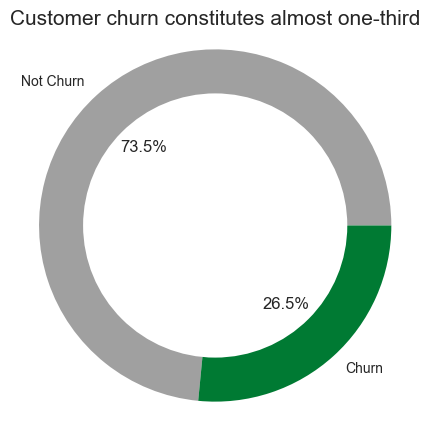

In [453]:
# import dataset
data = pd.read_csv('../data/raw_data.csv')

# get churn rate
target_col = pd.DataFrame(
    {'count': data['Churn'].value_counts(), 
     'proportion': round(data['Churn'].value_counts(normalize=True)*100, 2)
})

# create the donut chart
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ax.pie(target_col['count'], labels=['Not Churn', 'Churn'], autopct='%1.1f%%', colors=['#A0A0A0', '#007A33'])
centre_circle = plt.Circle((0, 0), 0.75, fc='white')
fig.gca().add_artist(centre_circle)
ax.axis('equal')

# show
plt.title('Customer churn constitutes almost one-third', fontdict={'fontsize': 15})
plt.show()

Given the importance of this issue, our main business concern is **how the company can decrease the customer churn issue by 10%** by both exploring the company's historical data and predicting the possibility of customers to churn. Analyzing historical data can provide an understanding of why customers churned in the past and can use the insights for data-driven decision making by the respective teams (e.g, Customer Success, Marketing, Product, Sales, and Finance) but the Customer Success team will be the most directly responsible team in the company for handling the churn as customer experience and churn reduction are their concerns. And for this reason, **the main stakeholder of the current project will be the Customer Experience team, especially the manager**. 

So, to achieve the main goal of reducing the churn rate by 10%, we break it down into two main objectives:

- **First, we aim to investigate the possible reasons for the churn**. From this analysis, the stakeholder can understand the possible reasons for past customers to churn and take necessary actions to mitigate the risk. While we can associate the churn with different factors in the data, the direct contributing factors of the churn remains an open question due to inavailability of data concerning customer's reason for leaving (e.g., via an open-ended survey). 

- **Second, we aim to build a classification model to predict whether a current customer will stop buying the company's products (churn) or not (not churn)**. After getting the prediction, we proceed identifying what factors contribute to the churn by investigating the predictitions. The model therefore can be used to flag customers with high probability of churn, and enables the stakeholders to proactively mitigate the possibility of churn by identifying at-risk customers. Besides, as the model can identify at-risk customers, the stakeholder can also prioritize outreach according to predicted churn risk so they can be more efficient in allocating resources.

<a id="basic"></a>
### <b><span style='color:darkblue'> 1.3. Success Metrics</span></b>

As we have two goals i.e. Data Analysis and Machine Learning Model, our project will involve different metrics for different purposes. For the data analysis, our main metric will be churn rate. In short, customer churn rate is the percentage of customers who stop making purchases from an online store within a specific period. And for the Machine Learning Model to predicting whether customer will churn, let us consider the following two possible misclassifications made by the classification model. The business impacts of each misclassification will guide us to determine which metric(s) is more suitable for the company's business case.

- **Type I Error (False Positive)**: This error happens when the model predicts a customer to churn when they actually don't. This misclassification leads to unnecessary retention actions, especially providing discounts for next purchase. In SaaS industry, the customer retention cost is 4 times cheaper than the customer acquisition cost, that is USD694 per customer ([FirstPageSage, 2024](https://firstpagesage.com/reports/average-customer-acquisition-cost-cac-by-industry-b2b-edition-fc/)), meaning the retention cost per customer will be around USD173.3. With these values, the company spends USD173,300 per 1000 misclassifications per month.

- **Type II Error (False Negative)** A model predicts a customer to not churn when actually they do. Making a type II error leads to the company to spend money on acquiring a new customer. According to [FirstPageSage (2024)](https://firstpagesage.com/reports/average-customer-acquisition-cost-cac-by-industry-b2b-edition-fc/), the customer acquisition cost (CAC) for e-commerce is USD694 per customer. As a consequence, for every 1000 mistakes, the model will cost USD694,000 per month. This significant revenue loss underscores the criticality of the prevention.

Since the financial cost of type II errors (false negatives) is significantly higher than type I errors (false positives), but without neglecting type I errors, we decided to use the F5 score as the evaluation metric for our classification model. The F5 score considers both recall and precision, with five times the weight given to recall. In other words, this value answers, “Of all the customers who actually churned, how well did the model predict these cases considering the precision of the prediction?” A high F5 value indicates that the model is effective in capturing a large number of positive cases (churners) and reduces the likelihood of significant financial costs due to undetected churn by focusing on minimizing type II errors.

<a id="numerical"></a>
## <b><span style='color:darkturquoise'>Section 2 |</span><span style='color:darkblue'> Data Examination & Preparation</span></b>

____

<a id="basic"></a>
### <b><span style='color:darkblue'> 2.1. Dataset Dictionary</span></b>

The dataset represents customer profiles who have left the telecommunication company. A churn in telco and other subscription-based services means a situation when the customer leaves the service provider.

In [454]:
# show
data.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2418,0141-YEAYS,Female,1,No,No,27,Yes,Yes,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Bank transfer (automatic),86.45,2401.05,No
4770,7762-ONLJY,Female,0,Yes,Yes,6,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.70,94.45,No
440,0771-WLCLA,Female,0,Yes,Yes,16,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,112.95,1882.55,No
1917,3219-JQRSL,Female,1,Yes,No,72,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),89.10,6352.4,No
2696,5472-CVMDX,Female,0,No,No,68,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,Two year,No,Mailed check,38.90,2719.2,No


At glance, we can see that the dataset contains:

1. **Demographics,** capture the customer’s personal information:

- `customerID`: A unique identifier for each customer
- `gender`: The gender of the customer
- `SeniorCitizen`: Indicates if the customer is a senior citizen
- `Partner`: Indicates if the customer has a partner
- `Dependents`: Indicates if the customer has dependents

2. **Service Subscription,** details the specific services used, which are key to understanding customer behavior and dissatisfaction:

- `tenure`: Number of months the customer has stayed with the company.
- `PhoneService`: Indicates if the customer has a phone service
- `MultipleLines`: Indicates if the customer has multiple phone lines
- `InternetService`: Type of internet service subscribed by the customer
- `OnlineSecurity`: Indicates if the customer has online security service
- `OnlineBackup`: Indicates if the customer has an online backup service
- `DeviceProtection`: Indicates if the customer has device protection service 
- `TechSupport`: Indicates if the customer has tech support service
- `StreamingTV`: Indicates if the customer has streaming TV service
- `StreamingMovies`: Indicates if the customer has streaming movie service

3. **Billing and Payment,** reflects customer affordability, preferences, and loyalty, which can significantly impact churn predictions:

- `Contract`: Type of contract the customer has
- `PaperlessBilling`: Indicates if the customer is enrolled in paperless billing
- `PaymentMethod`: Customer's payment method
- `MonthlyCharges`: The amount charged to the customer per month.
- `TotalCharges`: The total amount charged to the customer over the tenure period.

Please note that whether all variables will be used for data analysis and machine learning modeling will be determined based on findings during data exploration. Variables with moderate to high correlations, for example, may be excluded for later stages to avoid problems at the modeling stage, especially when using logistic regression. Multicollinearity can be another challenge when interpreting the contribution of each predictor to the prediction.

<a id="basic"></a>
### <b><span style='color:darkblue'> 2.2. Data Condition: Quality and Representativeness</span></b>

Unfound and unresolved issues around data quality will undermine the trust and accuracy of the work results, we built a function to perform a basic sanity check which will include column name, row count, data type, missing value rate, duplicate rate, unique value, and sample.

In [455]:
# convert TotalCharges to float64 data type
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# create function to inspect df
def inspect_dataframe(df):
    print(f'The dataframe contains {df.shape[0]} rows and {df.shape[1]} cols.')
    summary = {
        'ColumnName': df.columns.values.tolist(),
        'DataType': df.dtypes.values.tolist(),
        'NAPct': (df.isna().mean() * 100).round(2).tolist(),
        'DuplicatePct': (df.duplicated().sum()/len(df)*100).round(2),
        'Sample': [df[col].unique() for col in df.columns],
        'UniqueValue': df.nunique().tolist()
    }
    return pd.DataFrame(summary)

# perform inspection
inspect_dataframe(data)

The dataframe contains 7043 rows and 21 cols.


,ColumnName,DataType,NAPct,DuplicatePct,Sample,UniqueValue
0,customerID,object,0.00,0.0,"[7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOCW, 9237-HQITU, 9305-CDSKC, 1452-KIOVK, 6713-OKOMC,...",7043
1,gender,object,0.00,0.0,"[Female, Male]",2
2,SeniorCitizen,int64,0.00,0.0,"[0, 1]",2
3,Partner,object,0.00,0.0,"[Yes, No]",2
4,Dependents,object,0.00,0.0,"[No, Yes]",2
5,tenure,int64,0.00,0.0,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, 49, 25, 69, 52, 71, 21, 12, 30, 47, 72, 17, 27, 5,...",73
6,PhoneService,object,0.00,0.0,"[No, Yes]",2
7,MultipleLines,object,0.00,0.0,"[No phone service, No, Yes]",3
8,InternetService,object,0.00,0.0,"[DSL, Fiber optic, No]",3
9,OnlineSecurity,object,0.00,0.0,"[No, Yes, No internet service]",3


**Note**
- The dataset contains 7043 rows and 21 columns, consisting 18 object columns and 3 numerical columns.
- Represents 7043 different customers, indicated by the corresponding number of unique values.
- No missing value and duplicates value.
- The uniformity and coherence of data is good, consistent typography. 
- No categorical columns with high cardinality were found. All categorical columns contain less than 10 unique values.
- There are missing value (0.16%) found in the `TotalCharges` so treatments are needed.
- `SeniorCitizen` is a categorical variable, so it needs to be changed where “Yes” represents 1, and “No” represents 0.

<a id="basic"></a>
### <b><span style='color:darkblue'> 2.3. Data Size: Amount and Range</span></b>

Once we have established an understanding of the different types & quality of data, we can switch our examination towards the shape and size of this data, looking at the quantitative attributes across all variables. Statistical methods will assist in describing further physical characteristics. 

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.37,24.56,0.00,9.00,29.00,55.00,72.00
MonthlyCharges,7043.0,64.76,30.09,18.25,35.50,70.35,89.85,118.75
TotalCharges,7032.0,2283.30,2266.77,18.80,401.45,1397.48,3794.74,8684.80


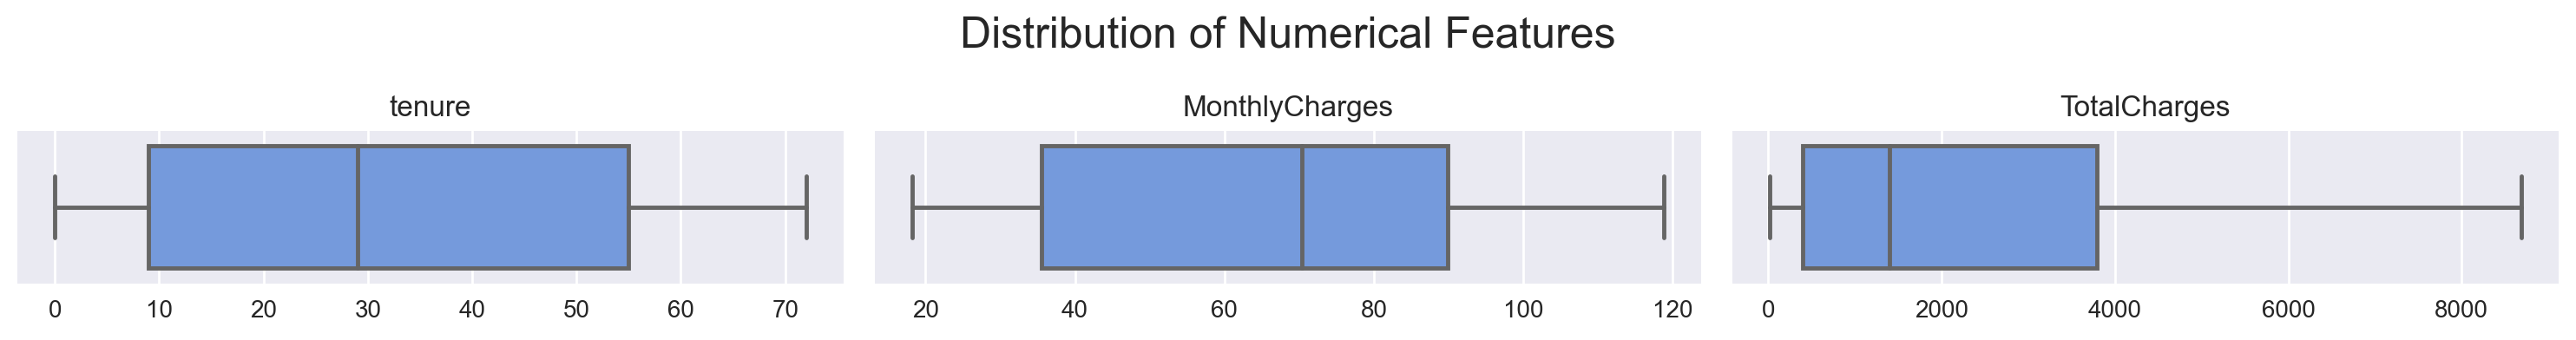

In [456]:
# get statistical summary for numerical var
display(data[['tenure', 'MonthlyCharges', 'TotalCharges']].describe().round(2).transpose())

# setup up figure size
plt.figure(figsize=(15, 7), dpi=200)
plt.suptitle('Distribution of Numerical Features', fontsize=18)

# check outliers using boxplots
for i, col in enumerate(['tenure', 'MonthlyCharges', 'TotalCharges']):
    plt.subplot(5, 3, i+1)
    sns.boxplot(x=data[col], color='cornflowerblue', orient='v')
    plt.title(f'{col}')
    plt.xlabel(None)

# show
plt.tight_layout()
plt.show()

**Note**

The box plots above display the distribution of three numerical features: tenure, MonthlyCharges, and TotalCharges. Each box plot provides insights into the spread, central tendency, and possible outliers for the respective features.

- **Tenure:** Most customers have been with the company for a moderate duration. 
    - The ranges from 0 (minimum) to approximately 70 (maximum) months. 
    - Half of the customers have a tenure between 9 and 55 months. 
    - 50% of the customers have a tenure of less than or equal to 29 months.
    - There are no apparent outliers in the tenure distribution, as all data points fall within the whiskers. 
    - The distribution appears slightly skewed to the right since the median is closer to the 25th percentile.
- **MonthlyCharges:** Customers’ monthly spending is centered around 70.35 USD, with a balanced distribution.
    - The feature ranges from around 18.25 (minimum) to approximately 118.75 (maximum) USD.
    - 50% of customers are charged between 35.5 and 89.9 USD per month.
    - The median is around 70.35 USD, which is the typical monthly charge for a customer.
    - No visible outliers are detected as all data points lie within the whiskers. 
    - The distribution seems fairly symmetric, with the median approximately in the center of the box.
- **TotalCharges:** This feature has significant variability and positive skewness, potentially influenced by tenure and monthly charges.
    - The feature ranges from 18.80 (minimum) to around 8684 (maximum) USD.
    - Half of the customers have a tenure between 2266 USD and 3794 USD.
    - The median is approximately 1397 USD, representing the typical total charges for a customer. 
    - There are potential extreme values in TotalCharges, indicated by the longer right whisker. 
    - These may represent high-value customers who have been subscribed for a long time or opted for premium services. The feature is positively skewed, as the median is closer to the 25th percentile and the whisker on the right is longer.
- Moreover, there seem to be no weird values in the dataset. For instance, there are no values lower than zeros. All values seem to be possible to happen in real-life. 

In [457]:
# get statistical summary for categorical var
data.describe(include='object', ).round(2).transpose()

,count,unique,top,freq
customerID,7043,7043,7590-VHVEG,1
gender,7043,2,Male,3555
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
PhoneService,7043,2,Yes,6361
MultipleLines,7043,3,No,3390
InternetService,7043,3,Fiber optic,3096
OnlineSecurity,7043,3,No,3498
OnlineBackup,7043,3,No,3088
DeviceProtection,7043,3,No,3095


**Note**

This table provides a statistical summary of the dataset, including categorical features. Below is a detailed interpretation of the table:
- **Services Adoption:** Essential services like PhoneService and InternetService are popular, but add-ons like OnlineSecurity and TechSupport have lower adoption rates.
- **Payment Behavior:** Most customers prefer electronic payment methods like Electronic Checks, highlighting the need to maintain user-friendly digital interfaces.
- **Churn Risk:** The preference for month-to-month contracts suggests potential vulnerability to churn, as customers with less commitment are more likely to leave.
- **Demographics:** The absence of dependents and preference for shorter contracts may point to a younger or less settled customer base.

<a id="basic"></a>
### <b><span style='color:darkblue'> 2.4. Data Transformation: Cleaning and Creating</span></b>

In this section, we performe a series of data preparation. The process here is primarily aimed for preparing data for an analysis on churns. Nonetheless, it is noteworthy that as the general purposes of data analysis and modeling are different, only basic data transformation was done. No pipelines or feature engineering techniques for numerical rescaling, imbalance treatment on the target feature, or encoding were applied.

In [458]:
# convert SeniorCitizen into categories (Yes or No)
data['SeniorCitizen'] = np.where(data['SeniorCitizen']==1, 'Yes', 'No')

# copy data for analysis purpose
df = data.copy()

# drop unused column
df.drop(columns='customerID', inplace=True)

# hanlde missing value on 'TotalCharges'
df.fillna(value={'TotalCharges': df['TotalCharges'].mode()[0]}, inplace=True)

To streamline data analysis and ensure consistency, we combined the value "No internet service" with the value "No" for the variables OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, and StreamingMovies. This transformation was applied only when the InternetService variable was "No". The rationale behind this adjustment is that customers without internet service cannot access these features, making "No internet service" logically equivalent to "No." By consolidating these values, we reduced redundancy and simplified the dataset, enabling more straightforward and meaningful analyses of service subscriptions and their impact on churn.

In [459]:
# list of variables to process
columns_to_update = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# replace 'No internet service' with 'No' where InternetService is 'No'
for col in columns_to_update:
    df.loc[df['InternetService'] == 'No', col] = 'No'

Also, we combined the value "No phone service" with the value "No" for the variables MultipleLines. This transformation was applied only when the PhoneService variable was "No".

In [460]:
# replace 'No phone service' with 'No' where PhoneService is 'No'
df.loc[df['PhoneService'] == 'No', 'MultipleLines'] = 'No'

<a id="numerical"></a>
## <b><span style='color:darkturquoise'>Section 3 |</span><span style='color:darkblue'> Data Exploration</span></b>

____

As discussed earlier in the Section 1, the ultimate goal is to decrease customer churn, and to this end, we firstly need to identify the characteristics of customers who churned. This identification will shed light on the possible contributing factors of the churn, and enable the Customer Success Manager as the key stakeholder of this project to take necessary action to mitigate the business impacts of the customer churn. This section explores the dataset by relating every feature (both categorical and numerical) to the target variable, i.e., `Churn`. By associating the features to `Churn` and comparing each feature based on the customer churn status (churn vs non-churn), it is expected to gain an understanding of the customers' characteristics who no longer make any purchases in the e-commerce platform.

To make this section more structured, we mainly divide Section 3 into three groups that do not overlap. The division will be further detailed by using questions to guide the analysis. However, before moving on to the first subsection, we will check out the overall churn rate in the telecommunication company as this will be the starting point for our analysis and data modeling, i.e., the overall churn rate in the telecommunication company.

1. **Customer Demographics (Who the Churned Customer Is?)**

    These factors provide context about the customer's personal background and characteristics.

    - Does the gender of a customer affect their likelihood to churn?
    - Are senior citizens more likely to churn compared to non-senior citizens?
    - Does having a partner influence the customer's likelihood of churning?
    - Do customers with dependents churn at a different rate than those without?

2. **Service Subscriptions (What Services the Churned Customer Uses?)**
    
    These factors relate to the type of service the customer subscribes to, which might impact their satisfaction and retention.

    - How long has the customer been with the company?
    - Does having a phone service affect churn rates?
    - Is there a difference in churn between customers with multiple phone lines vs. a single line?
    - Does the type of internet service (DSL, Fiber, No service) influence churn?
    - Do customers who subscribe to value-added services (OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, Streaming) experience fewer churn than those who do not?

3. **Billing and Payment (How the Churned Customer Pays?)**
    
    These factors represent the customer's financial capability, ease of transaction, and whether the cost of the service is perceived as worth it.

    - Do customers on month-to-month contracts churn more than those on one- or two-year contracts?
    - Does opting for paperless billing impact churn rates?
    - Do customers with certain payment methods (e.g., electronic check vs. credit card) churn more frequently?
    - How do monthly charges and the total amount spent by customers influence their likelihood of churn?

4. **Cross-Category Analysis (What Drives Customer Loyalty?)**

    - How does tenure interact with contract type and monthly charges to impact churn?
    - How does the bundling of InternetService, PhoneService, and additional services relate to churn behavior?
    - What role does the combination of tenure, contract type, and service add-ons play in churn reduction?

**Note**

This section is structured in this way: We firstly show the count of each categories by churn status to get the overview of the feature, specifically about how customer churn varies across categories. Nonetheless, since simple count only provides us with an incomplete story, we incorporate churn rate per category in a feature to give us a better understanding the churn risk. Afterwards, we conduct a hypothesis test to determine if there is a significant statistical relationship between the churn status and the variables. If the statistical test shows a significant association, it means there is a notable relationship between customer churn and the category in question. This insight helps us identify which categories are more prone to churn, allowing us to implement targeted strategies to address these specific areas and potentially reduce overall churn rates.

<a id="basic"></a>
### <b><span style='color:darkblue'> 3.1 Customer Demographic</span></b>

Analyzing customer demographics is a crucial step in understanding the factors that influence churn status. Demographic attributes such as gender, partner, and whether the customer is a senior citizen or has dependents often provide valuable insights into customer behavior and loyalty. These characteristics can reveal specific patterns or trends, such as which groups are more likely to leave the service and why. By identifying demographic factors strongly associated with churn, businesses can develop targeted strategies to retain high-risk customers, improve overall satisfaction, and enhance customer lifetime value. This analysis also serves as a foundation for creating personalized marketing campaigns and optimizing customer service efforts, ensuring that the company addresses the needs of its diverse customer base effectively.

#### **Q1. Does the gender of a customer affect their likelihood to churn?**

To answer this question, we will begin by examining the simple count of gender among churners and non-churners. Additionally, we will also calculate the churn rate for each gender.

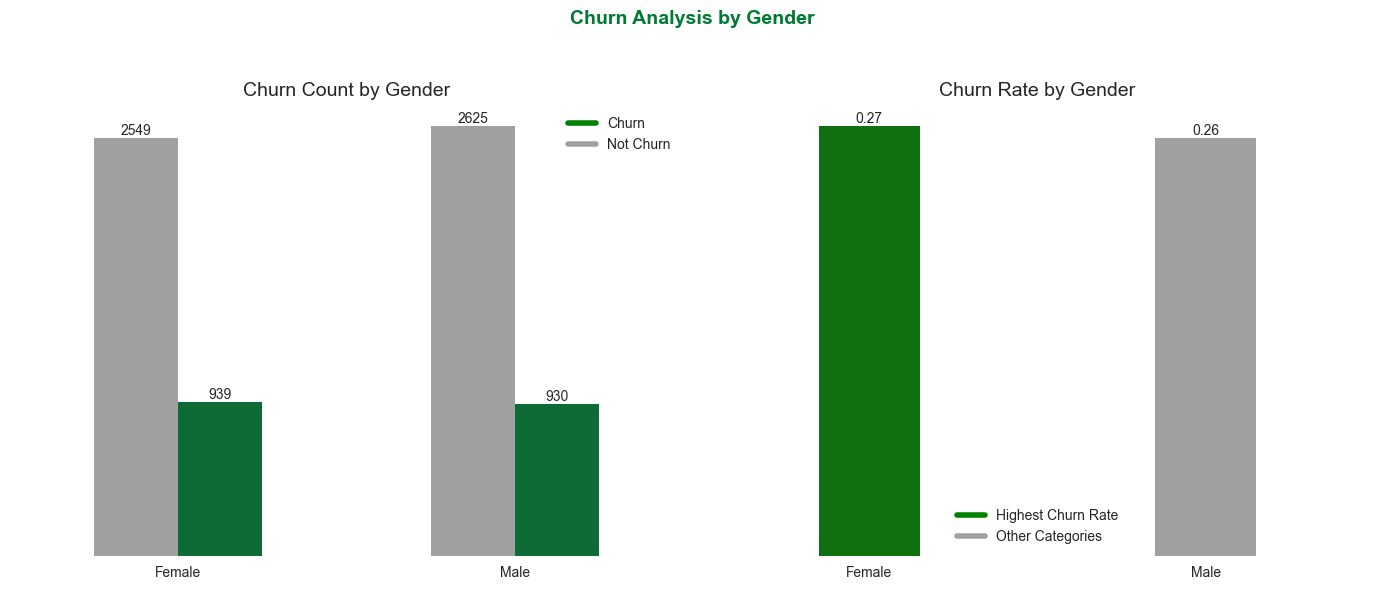

Chi-Square Statistic: 0.4841
P-Value: 0.4866
Effect size: Negligible


In [461]:
# Visualize churn distribution by the 'gender' variable
plot_bar_churn_comparison(df, var_col='gender', churn_col='Churn')

# Perform a chi-square test for the 'gender' variable
chi2_with_effect_size(df, var_col='gender', churn_col='Churn')

**Note**

The analysis of churn by gender reveals the following details: Among female customers, there are 3,488 total customers, with 939 having churned, resulting in a churn rate of 26.9%. On the other hand, male customers total 3,555, with 930 churned, leading to a churn rate of 26.2%. The Chi-Square statistic of 0.4841 and a p-value of 0.4866 suggest that there is no statistically significant difference in churn rates between males and females. The relatively similar churn rates (26.9% for females vs 26.2% for males) further supports the conclusion that gender does not play a substantial role in determining customer churn.

#### **Q2. Are senior citizens more likely to churn compared to non-senior citizens?**

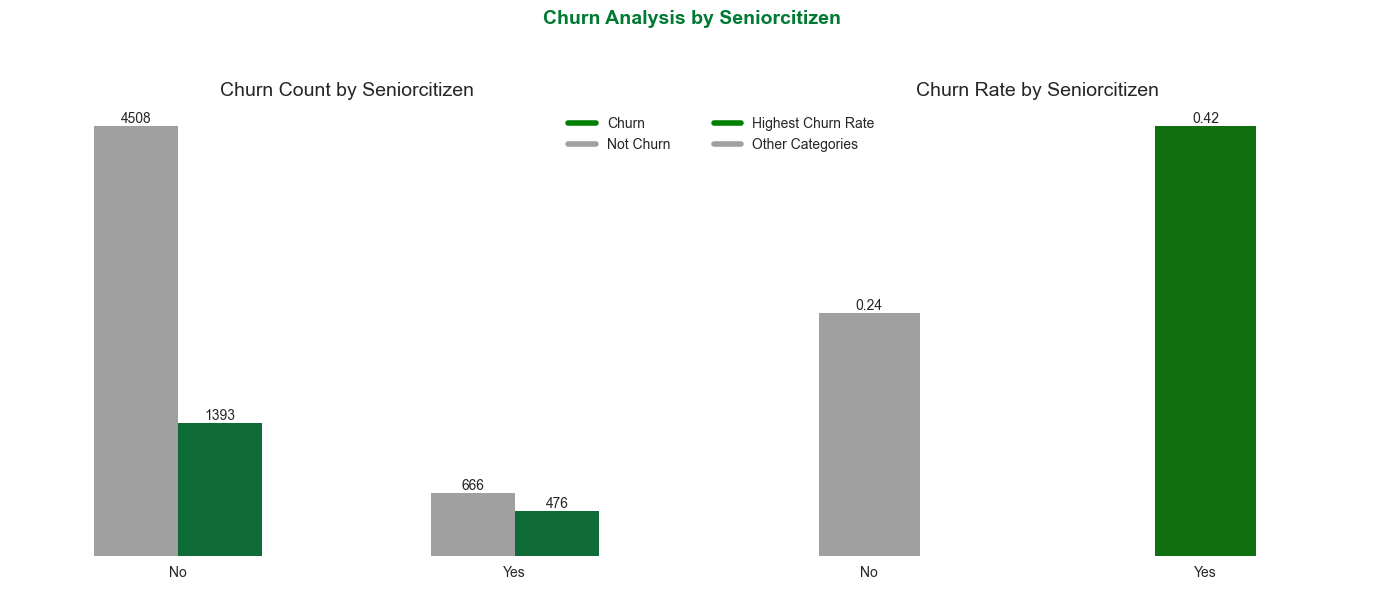

Chi-Square Statistic: 159.4263
P-Value: 0.0000
Effect size: Small


In [462]:
# Visualize churn distribution by the 'SeniorCitizen' variable
plot_bar_churn_comparison(df, var_col='SeniorCitizen', churn_col='Churn')

# Perform a chi-square test for the 'SeniorCitizen' variable
chi2_with_effect_size(df, var_col='SeniorCitizen', churn_col='Churn')

**Note**

The analysis of churn by senior citizen status reveals notable differences between non-senior citizens and senior citizens. Among non-senior citizens, the total customer base consists of 5,901 individuals, with 1,393 customers who churned, resulting in a churn rate of 23.6%. On the other hand, senior citizens, with a total customer count of 1,142, show a significantly higher churn rate of 41.7%, with 476 customers having churned. The Chi-Square statistic of 159.4263 and a p-value of 0.0000 confirm that this difference is statistically significant, indicating that senior citizens are much more likely to churn than non-senior citizens.

#### **Q3. Does having a partner influence the customer's likelihood of churning?**

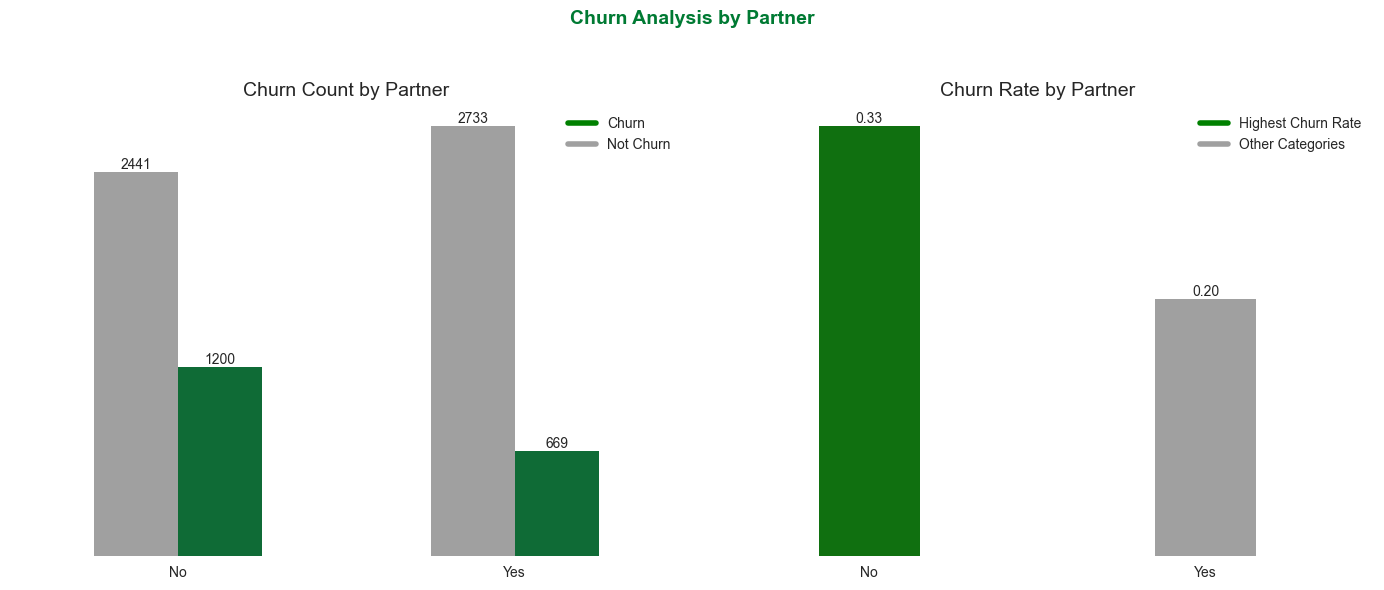

Chi-Square Statistic: 158.7334
P-Value: 0.0000
Effect size: Small


In [463]:
# Visualize churn distribution by the 'Partner' variable
plot_bar_churn_comparison(df, var_col='Partner', churn_col='Churn')

# Perform a chi-square test for the 'Partner' variable
chi2_with_effect_size(df, var_col='Partner', churn_col='Churn')


**Note**

The analysis of churn based on partnership status reveals a significant difference between customers with and without partners. Among customers without a partner, there are 3,641 total customers, of whom 1,200 have churned, resulting in a churn rate of 33.0%. In contrast, among customers with a partner, the total number of customers is 3,402, with 669 having churned, leading to a much lower churn rate of 19.7%. The statistical test further supports the significance of this difference, as indicated by a Chi-Square statistic of 158.7334 and a p-value of 0.0000, which confirms that the relationship between partnership status and churn is statistically significant.

#### **Q4. Do customers with dependents churn at a different rate than those without?**

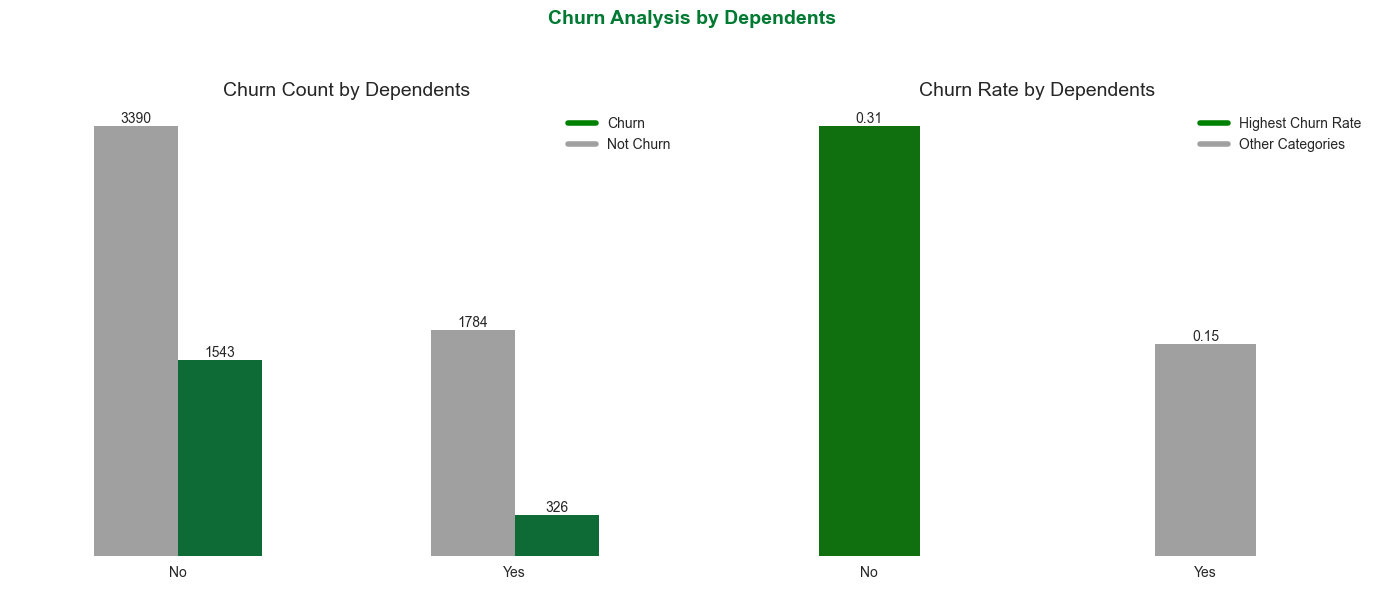

Chi-Square Statistic: 189.1292
P-Value: 0.0000
Effect size: Small


In [464]:
# Visualize churn distribution by the 'Dependents' variable
plot_bar_churn_comparison(df, var_col='Dependents', churn_col='Churn')

# Perform a chi-square test for the 'Dependents' variable
chi2_with_effect_size(df, var_col='Dependents', churn_col='Churn')

**Note**

The analysis of customer churn based on dependency status reveals a significant difference in churn rates between non-dependents and dependents. Among non-dependents, there is a total of 4,933 customers, with 1,543 customers having churned, which translates to a churn rate of 31%. In contrast, among dependents, there are 2,110 total customers, and only 326 of them have churned, resulting in a lower churn rate of 15%. The Chi-Square test statistic of 189.1292 and a p-value of 0.0000 indicate a statistically significant relationship between dependency status and churn, meaning that the likelihood of a customer churning is strongly influenced by whether they are classified as dependents or non-dependents.

<a id="basic"></a>
### <b><span style='color:darkblue'> 3.2 Service Subscriptions</span></b>

Analyzing factors related to customer churn based on service usage and product subscription is essential for understanding the key drivers behind customer retention and attrition. Service usage, such as the frequency or type of services accessed by customers, provides valuable insights into customer engagement and satisfaction levels. Similarly, product subscription details, including add-ons like streaming services, internet plans, or additional phone lines, reveal patterns in customer preferences and their perceived value of the services offered. By exploring these factors, businesses can identify specific services or subscription models that contribute to higher churn rates and develop targeted strategies to enhance customer satisfaction, optimize offerings, and reduce churn effectively. This analysis not only aids in retaining existing customers but also helps in improving overall service design to meet diverse customer needs.

#### **Q1. How long has the customer been with the company?**

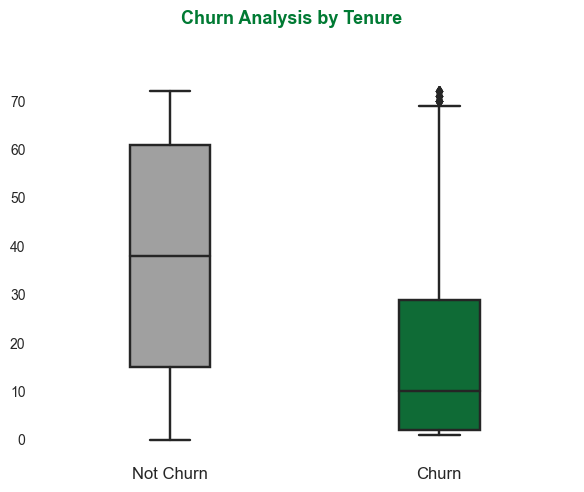

Mann-Whitney U Statistic: 2515538.0000
P-Value: 0.0000
Effect size cannot be computed.


In [465]:
# Visualize churn distribution by the 'tenure' variable
plot_boxplot_churn_comparison(df, 'tenure', 'Churn')

# Perform a mannu test for the 'tenure' variable
mannu_with_effect_size(df, 'tenure', 'Churn')

**Note**

Customers who did not churn generally have a higher median tenure, with a wider interquartile range (IQR) spanning approximately 25 to 50 months, compared to churned customers whose tenure is clustered toward lower values, with the median below 10 months. The Mann-Whitney U test results, with p-value of 0.0000 indicate a statistically significant difference in tenure between the two groups. This suggests that longer tenure is strongly associated with reduced churn likelihood.

#### **Q2. Does having a phone service affect churn rates?**

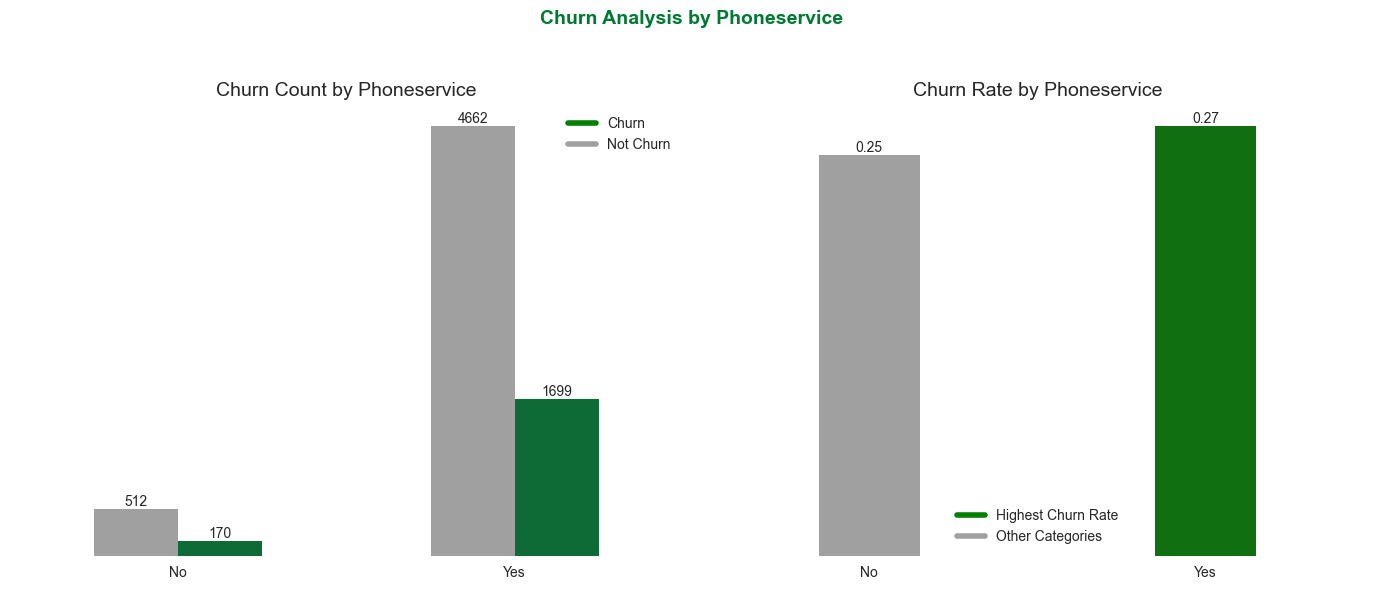

Chi-Square Statistic: 0.9150
P-Value: 0.3388
Effect size: Negligible


In [466]:
# Visualize churn distribution by the 'PhoneService' variable
plot_bar_churn_comparison(df, var_col='PhoneService', churn_col='Churn')

# Perform a chi-square test for the 'PhoneService' variable
chi2_with_effect_size(df, var_col='PhoneService', churn_col='Churn')

**Note**

The analysis of churn based on phone service status reveals minimal differences between customers with and without phone service. Among customers without phone service, there are 682 total customers, of which 170 have churned, resulting in a churn rate of 25%. Meanwhile, for customers with phone service, the total number is significantly higher at 6,361, with 1,699 churned customers, leading to a slightly higher churn rate of 27%. Despite the small variance in churn rates, the statistical test does not support a significant relationship between phone service status and churn. The Chi-Square statistic is 0.9150, and the p-value of 0.3388 indicates no statistically significant difference in churn behavior between the two groups.

#### **Q3. Is there a difference in churn between customers with multiple phone lines vs. a single line?**

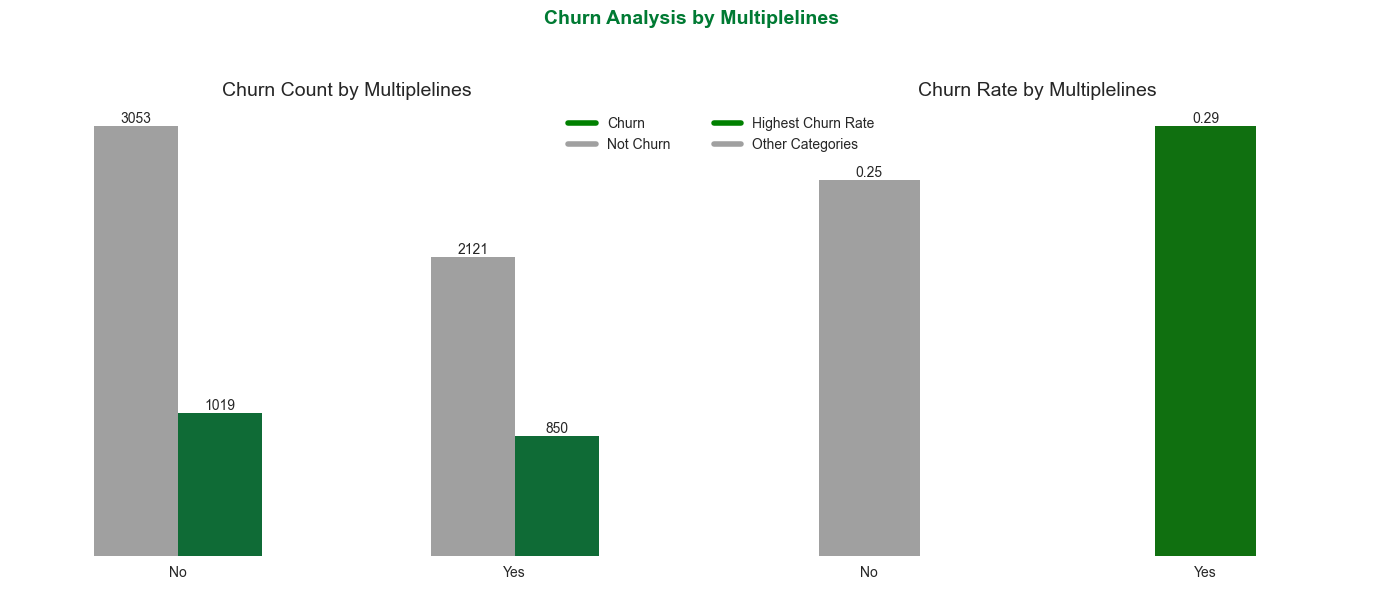

Chi-Square Statistic: 11.1433
P-Value: 0.0008
Effect size: Negligible


In [467]:
# Visualize churn distribution by the 'MultipleLines' variable
plot_bar_churn_comparison(df, var_col='MultipleLines', churn_col='Churn')

# Perform a chi-square test for the 'MultipleLines' variable
chi2_with_effect_size(df, var_col='MultipleLines', churn_col='Churn')

**Note**

The analysis examines the relationship between having multiple phone lines and customer churn. Among customers without multiple phone lines, there are 3,053 who did not churn and 1,019 who did, resulting in a churn rate of 25%. For customers with multiple phone lines, 2,121 did not churn while 850 churned, yielding a higher churn rate of 29%. The chi-square test produces a statistic of 11.1433 with a p-value of 0.0008, indicating that the relationship between having multiple phone lines and churn is statistically significant. This suggests that customers with multiple phone lines are more likely to churn compared to those without, warranting further investigation into the reasons behind this trend.

#### **Q4. Does the type of internet service (DSL, Fiber, No service) influence churn?**

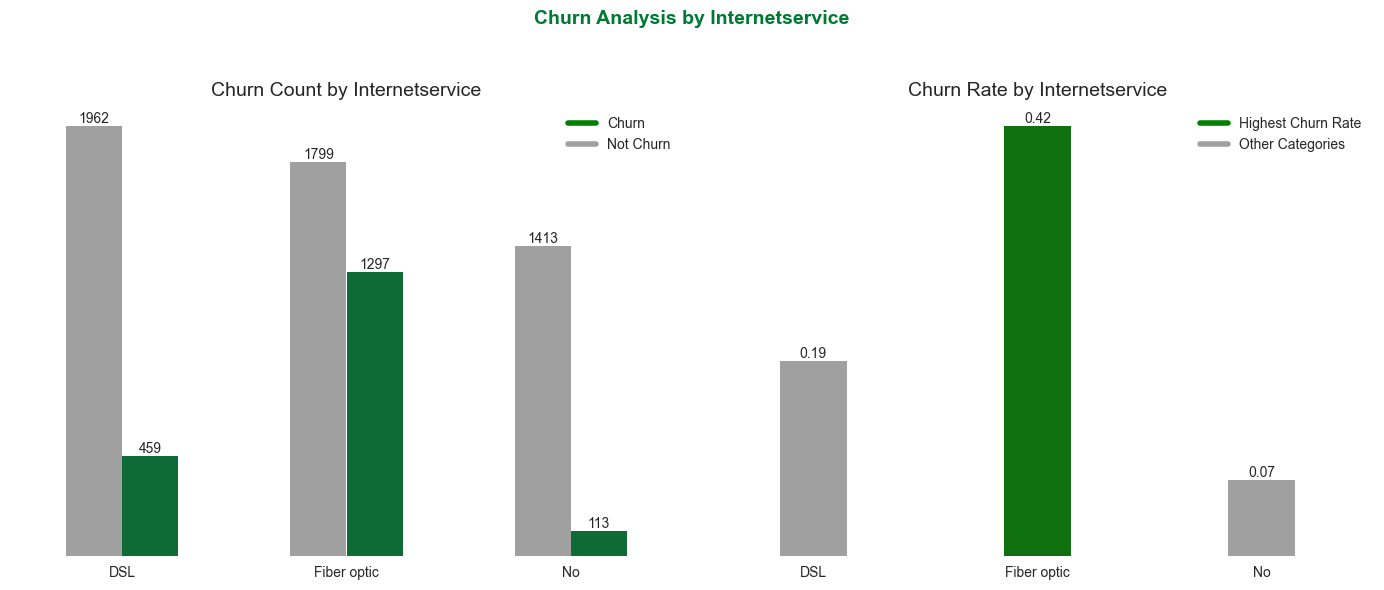

Chi-Square Statistic: 732.3096
P-Value: 0.0000
Effect size: Medium


In [468]:
# Visualize churn distribution by the 'InternetService' variable
plot_bar_churn_comparison(df, var_col='InternetService', churn_col='Churn')

# Perform a chi-square test for the 'InternetService' variable
chi2_with_effect_size(df, var_col='InternetService', churn_col='Churn')

**Note**

The analysis of churn based on internet service type reveals significant disparities in churn rates among different customer groups. Customers with DSL internet service exhibit a churn rate of 19%, with 459 churned customers out of a total of 2,421. In contrast, customers with fiber optic internet service show a much higher churn rate of 42%, with 1,297 churned customers out of 3,096. On the other hand, customers without internet service experience the lowest churn rate at just 7%, with 113 churned customers out of 1,526. 
The Chi-Square test yields a statistic of 732.3096 and a p-value of 0.0000, indicating a highly significant relationship between the type of internet service and customer churn. This result underscores the substantial impact that internet service type has on churn behavior.

#### **Q5. Do customers who subscribe to value-added services experience fewer churn than those who do not?**

In [469]:
# list columns to analyze
columns_to_analyze = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# dataFrame to store the results
results = pd.DataFrame()

for col in columns_to_analyze:
    # generate a crosstab
    contingency_table = pd.crosstab(df[col], df['Churn'])
    contingency_table.rename_axis(columns={'Churn': ''}, inplace=True)
    
    # perform the chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # perform the Cramér's V
    n = contingency_table.sum().sum()  # Jumlah total observasi
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
    
    # add results to the DataFrame
    contingency_table['Total'] = contingency_table.sum(axis=1)  # add the total count
    contingency_table['Churn Rate (%)'] = (contingency_table['Yes'] / contingency_table['Total'] * 100).round(2)  # calculate and add churn rate
    contingency_table['Chi2 Stats'] = np.round(chi2, 5)  # add the chi2 value
    contingency_table['P-value'] = np.round(p, 5)  # add the p-value
    contingency_table['Effect Size'] = cramers_v  # add the effect size
    contingency_table['Services'] = col  # add the feature name
    
    # apply a multi-index for combined results
    contingency_table = contingency_table.reset_index().set_index(['Services', col])
    results = pd.concat([results, contingency_table])

# display the results
results.drop(columns='Total', inplace=True)
results.rename_axis(index={'OnlineSecurity': ''}, inplace=True)
results.rename(columns={'No': 'Not Churn', 'Yes': 'Churn'}, inplace=True)
results.round(2)

Not Churn  Churn  Churn Rate (%)  Chi2 Stats  P-value  \
Services                                                                      
OnlineSecurity   No        3450   1574           31.33      205.63      0.0   
                 Yes       1724    295           14.61      205.63      0.0   
OnlineBackup     No        3268   1346           29.17       47.26      0.0   
                 Yes       1906    523           21.53       47.26      0.0   
DeviceProtection No        3297   1324           28.65       30.51      0.0   
                 Yes       1877    545           22.50       30.51      0.0   
TechSupport      No        3440   1559           31.19      190.17      0.0   
                 Yes       1734    310           15.17      190.17      0.0   
StreamingTV      No        3281   1055           24.33       27.86      0.0   
                 Yes       1893    814           30.07       27.86      0.0   
StreamingMovies  No        3260   1051           24.38       26.25      0.0   
                 Yes       1914    818           29.94       26.25      0.0   

                      Effect Size  
Services                           
OnlineSecurity   No          0.17  
                 Yes         0.17  
OnlineBackup     No          0.08  
                 Yes         0.08  
DeviceProtection No          0.07  
                 Yes         0.07  
TechSupport      No          0.16  
                 Yes         0.16  
StreamingTV      No          0.06  
                 Yes         0.06  
StreamingMovies  No          0.06  
                 Yes         0.06

**Note**

The table presents an analysis of customer churn based on their subscription to various services. Services like OnlineSecurity, OnlineBackup, DeviceProtection, and TechSupport show a clear association with lower churn rates, suggesting they play a role in retaining customers. In contrast, StreamingTV and StreamingMovies are linked to higher churn rates, indicating they might not be as effective in preventing churn. The statistically significant chi-square results across all services (p-value = 0.0000) reinforce the validity of these findings. Businesses should consider focusing on promoting essential security and support services to reduce churn while reevaluating the impact of entertainment-related services.

<a id="basic"></a>
### <b><span style='color:darkblue'> 3.3 Billing & Payment</span></b>

Understanding the factors influencing customer churn is critical for businesses aiming to improve retention rates and maintain sustainable growth. Among the key factors, the type of contract and billing method play a significant role in determining a customer's likelihood to churn. Contract type—whether it is month-to-month, one-year, or two-year—directly impacts the commitment level of customers, with shorter contracts often associated with higher churn rates due to their flexibility. Similarly, billing methods, such as electronic billing versus mailed invoices, may influence customer satisfaction and ease of payment, which can indirectly affect retention. This analysis focuses on evaluating the relationship between these variables and churn behavior, aiming to uncover actionable insights that can guide strategies for improving customer loyalty and reducing churn. By identifying patterns and statistical significance, businesses can better tailor their offerings to meet customer needs and preferences.

#### **Q1. Do customers on month-to-month contracts churn more than those on one- or two-year contracts?**

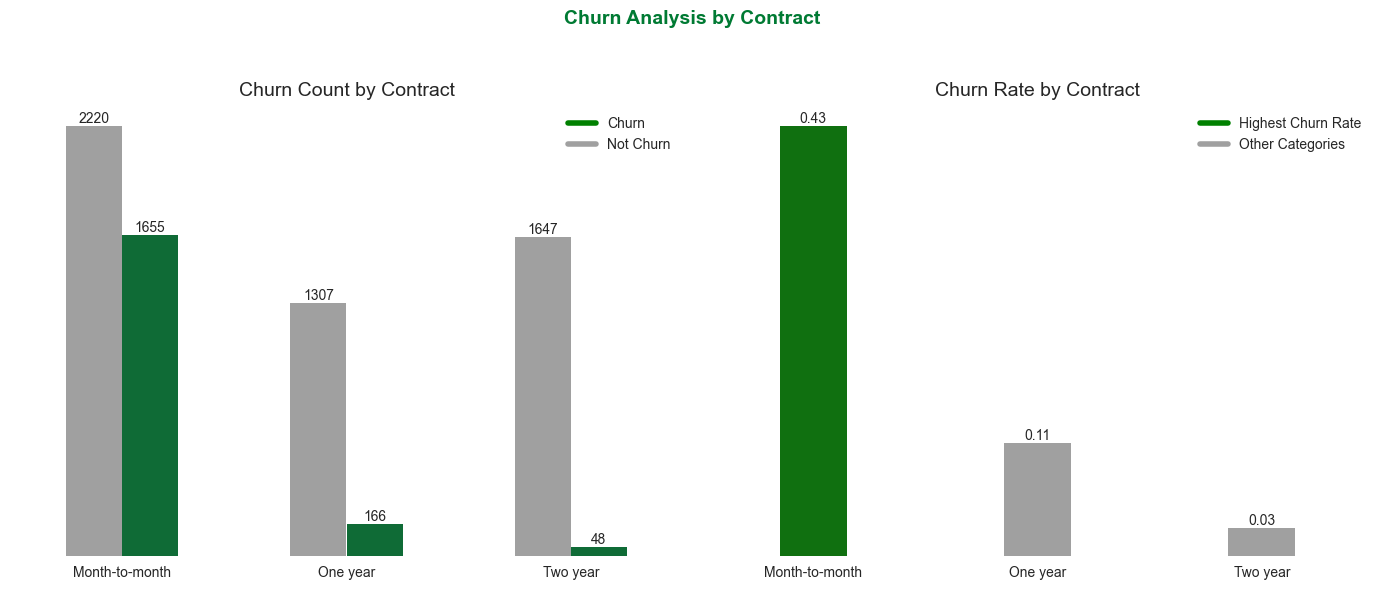

Chi-Square Statistic: 1184.5966
P-Value: 0.0000
Effect size: Medium


In [470]:
# Visualize churn distribution by the 'Contract' variable
plot_bar_churn_comparison(df, var_col='Contract', churn_col='Churn')

# Perform a chi-square test for the 'Contract' variable
chi2_with_effect_size(df, var_col='Contract', churn_col='Churn')

**Note**

The analysis of customer churn rates across different contract types reveals a clear and significant relationship between the type of contract and the likelihood of churn. Customers with month-to-month contracts exhibit the highest churn rate at 43%, with 1,655 out of 3,875 customers discontinuing the service. This group, characterized by its flexibility and lack of long-term commitment, appears to be the most vulnerable to churn. In contrast, customers with one-year contracts have a significantly lower churn rate of 11%, with only 166 out of 1,473 customers leaving. The lowest churn rate, at 3%, is observed among customers with two-year contracts, where only 48 out of 1,695 customers discontinue the service. The Chi-Square Statistic of 1,184.5966 and a p-value of 0.0000 confirm that the relationship between contract type and churn is statistically significant. This finding suggests that customers on longer-term contracts are far less likely to churn, likely due to stronger commitment and potential benefits such as discounted rates or additional perks.

#### **Q2. Does opting for paperless billing impact churn rates?**

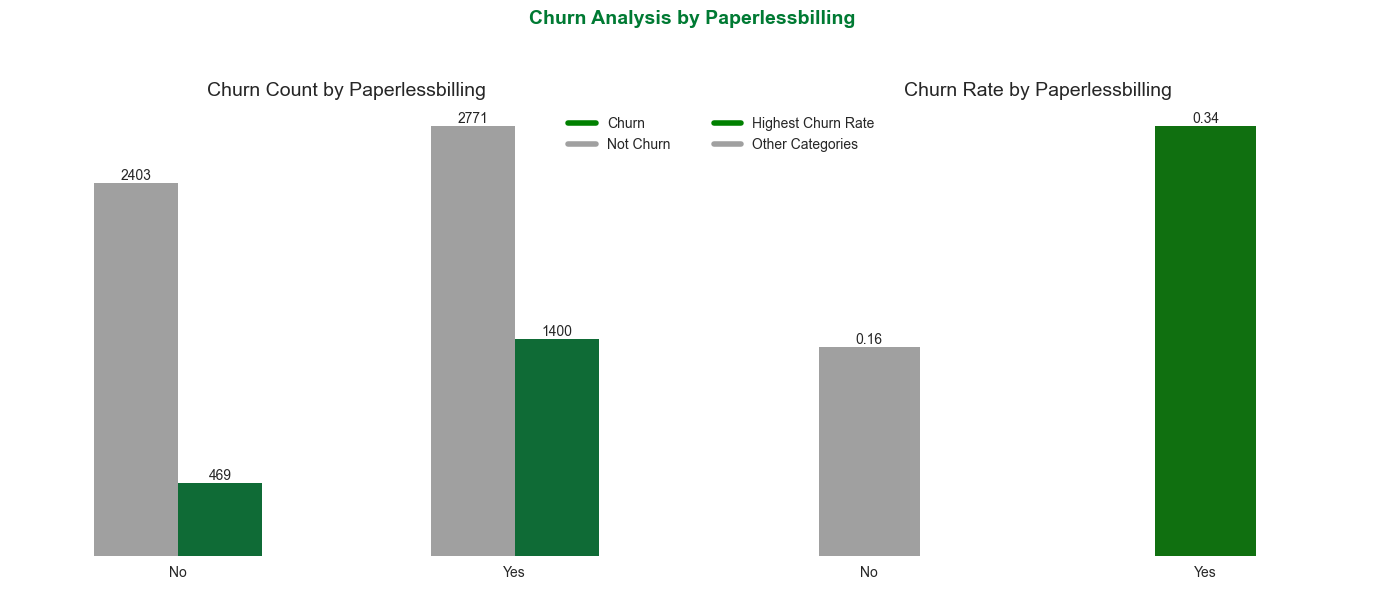

Chi-Square Statistic: 258.2776
P-Value: 0.0000
Effect size: Small


In [471]:
# Visualize churn distribution by the 'PaperlessBilling' variable
plot_bar_churn_comparison(df, var_col='PaperlessBilling', churn_col='Churn')

# Perform a chi-square test for the 'PaperlessBilling' variable
chi2_with_effect_size(df, var_col='PaperlessBilling', churn_col='Churn')

**Note**

The analysis of churn rates based on the adoption of paperless billing reveals a significant difference in customer behavior. Customers who do not use paperless billing exhibit a relatively low churn rate of 16%, with 469 out of 2,872 customers leaving the service. In contrast, customers who have opted for paperless billing demonstrate a much higher churn rate of 34%, with 1,400 out of 4,171 customers discontinuing their subscription. The chi-square test statistic of 258.2776 and a p-value of 0.0000 indicate that the relationship between paperless billing and churn is statistically significant. This highlights a strong association between the choice of billing method and the likelihood of customer churn.

#### **Q3. Do customers with certain payment methods (e.g., electronic check vs. credit card) churn more frequently?**

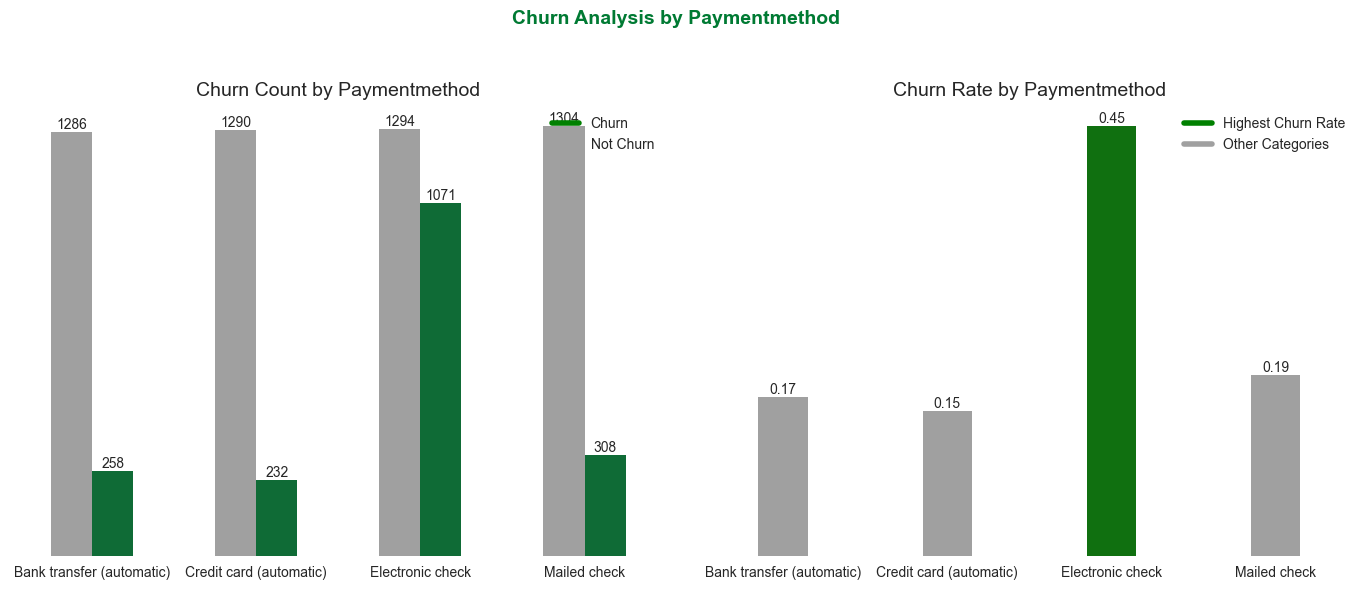

Chi-Square Statistic: 648.1423
P-Value: 0.0000
Effect size: Medium


In [472]:
# Visualize churn distribution by the 'PaymentMethod' variable
plot_bar_churn_comparison(df, var_col='PaymentMethod', churn_col='Churn')

# Perform a chi-square test for the 'PaymentMethod' variable
chi2_with_effect_size(df, var_col='PaymentMethod', churn_col='Churn')

**Note**

The analysis of churn rates based on different payment methods reveals significant disparities that highlight their impact on customer retention. Among customers using bank transfer (automatic), 258 out of 1,544 have churned, resulting in a churn rate of 17%, while those utilizing credit card (automatic) have an even lower churn rate of 15%, with 232 out of 1,522 customers leaving. In contrast, electronic check users experience the highest churn rate at a staggering 45%, with 1,071 out of 2,365 customers discontinuing their service. Meanwhile, customers paying via mailed check have a churn rate of 19%, with 308 out of 1,612 leaving the service. The chi-square test statistic of 648.1423 and an extremely low p-value of 0.0000 indicate that the relationship between payment methods and churn is statistically significant. This suggests that the type of payment method is strongly associated with a customer's likelihood of churn.

#### **Q4. How do monthly charges and the total amount spent by customers influence their likelihood of churn?**

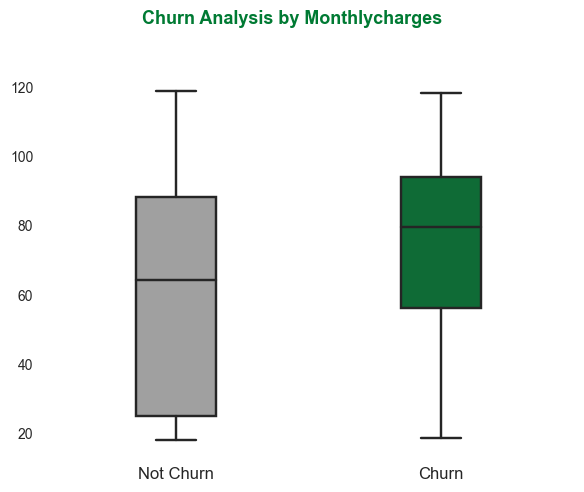

Mann-Whitney U Statistic: 6003125.5000
P-Value: 0.0000
Effect size cannot be computed.


In [473]:
# Visualize churn distribution by the 'MonthlyCharges' variable
plot_boxplot_churn_comparison(df, 'MonthlyCharges', 'Churn')  

# Perform a mannu test for the 'MonthlyCharges' variable
mannu_with_effect_size(df, 'MonthlyCharges', 'Churn')

**Note**

The median monthly charges for customers who churn are visibly higher compared to those who do not churn, indicating that customers paying more per month are more likely to leave. With p-value of 0.0000 from the Mann-Whitney U test confirm that the difference in distributions is statistically significant. This suggests that higher monthly charges may be a key driver of churn, potentially due to dissatisfaction with pricing or perceived lack of value for the cost.

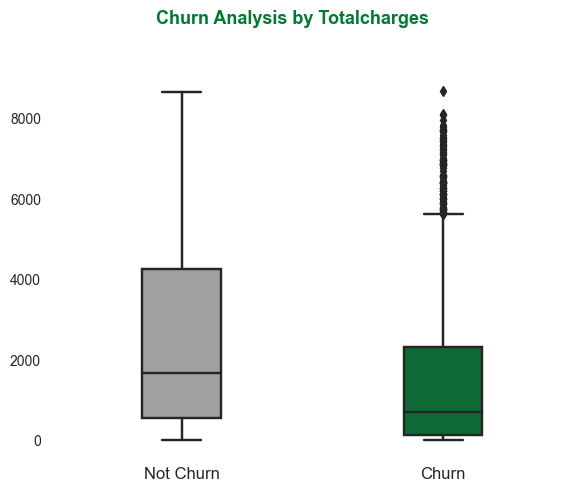

Mann-Whitney U Statistic: 3380795.0000
P-Value: 0.0000
Effect size cannot be computed.


In [474]:
# Visualize churn distribution by the 'TotalCharges' variable
plot_boxplot_churn_comparison(df, 'TotalCharges', 'Churn')  

# Perform a mannu test for the 'TotalCharges' variable
mannu_with_effect_size(df, 'TotalCharges', 'Churn')

**Note**

Customers who churn generally have lower total charges compared to those who remain, as indicated by the lower median and narrower range for the churn group. The Mann-Whitney U test result with p-value of 0.0000 confirms that the difference between the distributions is statistically significant. This trend suggests that customers with shorter tenures, and therefore lower total charges, are more likely to churn. 

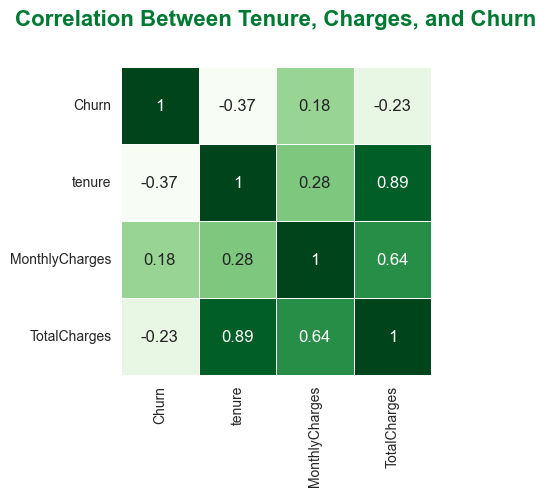

In [481]:
# define a list of columns to analyze for correlation
cols_to_plot = ['Churn', 'tenure', 'MonthlyCharges', 'TotalCharges']

# set the figure size
plt.figure(figsize=(4, 4))

# calculate the Spearman correlation matrix
correlation_matrix = df[cols_to_plot].replace(to_replace={'Yes':1, 'No':0}).corr(numeric_only=True, method='spearman').round(2)

# create a heatmap to visualize
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', linewidths=0.5, cbar=False)
plt.title('Correlation Between Tenure, Charges, and Churn', loc='center', fontsize=16, fontweight='bold', color='#007A33', pad=30)

# show
plt.show()

**Note**
- The heatmap presents the Spearman correlation coefficients between customer churn and purchasing behavior variables, including tenure, MonthlyCharges, and TotalCharges. The variable tenure shows a negative correlation with churn (-0.37), suggesting that customers with longer tenures are less likely to churn, indicating that loyalty and sustained engagement reduce the likelihood of leaving. Conversely, MonthlyCharges exhibits a weak positive correlation with churn (0.18), implying that customers paying higher recurring fees are slightly more prone to churn, potentially due to cost sensitivity. For TotalCharges, the correlation with churn is also negative (-0.23), consistent with the notion that customers with higher cumulative spending—often a byproduct of longer tenure—are less likely to churn. 
- Strong positive correlations between tenure and TotalCharges (0.89), and between MonthlyCharges and TotalCharges (0.64), underline the interconnectedness of these variables, as longer-tenured customers typically accumulate higher total charges and higher monthly charges contribute to larger overall spending. These insights suggest that tenure and cumulative spending are critical factors for retention, while monthly charges might need to be optimized to reduce churn risk.

<a id="basic"></a>
### <b><span style='color:darkblue'> 3.4 Cross-Category Analysis</span></b>

Traditional analyses, as outlined in Sections 3.1 to 3.3, typically focus on individual factors influencing customer churn. In contrast, Cross-Category Analysis offers a more comprehensive perspective by examining the interactions and relationships between variables across multiple categories. This approach explores how dimensions such as demographics, service subscriptions, and billing behaviors interact to influence churn. By uncovering these cross-dimensional insights, it becomes possible to identify hidden patterns and interdependencies that remain obscured in univariate or bivariate analyses.

#### **Q1. How does tenure interact with contract type and monthly charges to impact churn?**

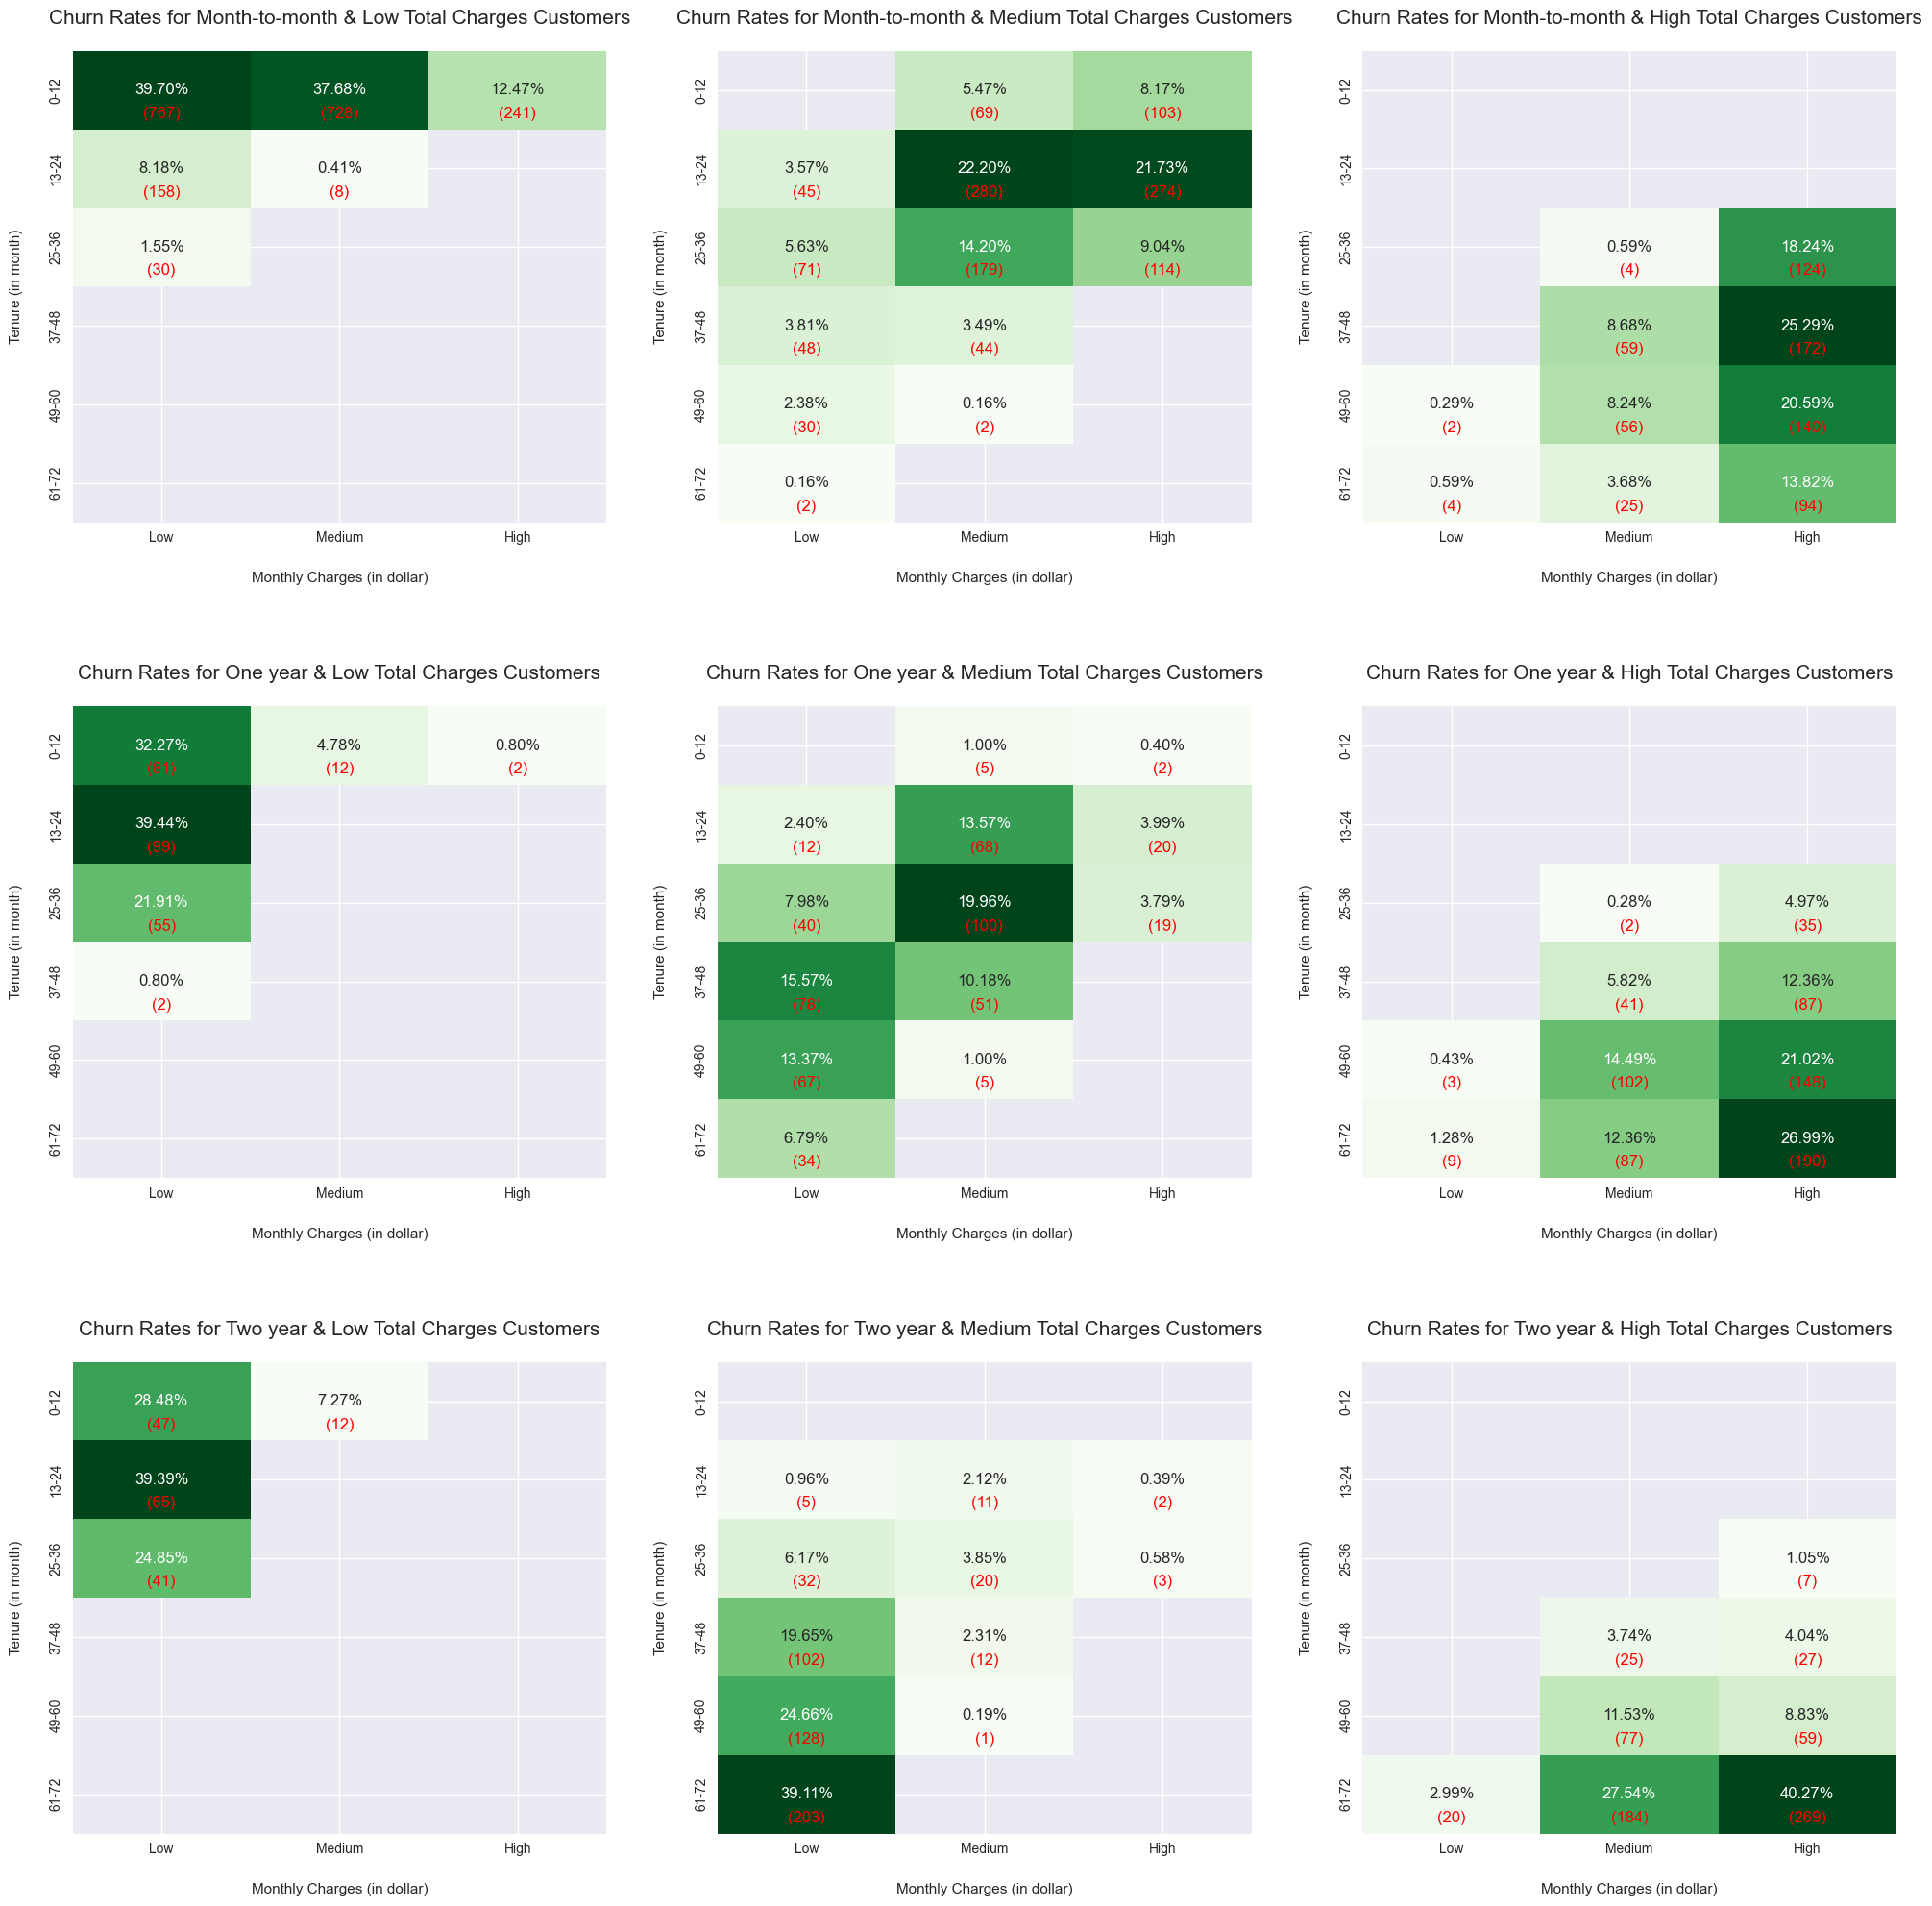

In [476]:
# Group customers into high, medium, low based on TotalCharges quartiles
df['TotalChargesCategory'] = pd.qcut(df['TotalCharges'], q=3, labels=['Low', 'Medium', 'High'])

# Create monthly charges bins
df['MonthlyChargesCategory'] = pd.qcut(df['MonthlyCharges'], q=3, labels=['Low', 'Medium', 'High'])

# Create tenure bins
df['TenureCategory'] = pd.cut(df['tenure'], bins=[0, 12, 24, 36, 48, 60, 72], 
                            labels=['0-12', '13-24', '25-36', '37-48', '49-60', '61-72'], right=False)

# Calculate churn rates for each group (contract type, total charges category, tenure bin, monthly bin)
churn_rate = df.groupby(['Contract', 'TotalChargesCategory', 'TenureCategory', 'MonthlyChargesCategory', 'Churn']).size().reset_index(name='Count')

# Create a heatmap for each contract type and total charges category
fig, axes = plt.subplots(3, 3, figsize=(20, 20), sharey=False)

# Loop through contract types and total charge categories
for i, contract in enumerate(['Month-to-month', 'One year', 'Two year']):
    for j, category in enumerate(['Low', 'Medium', 'High']):
        ax = axes[i, j]

        # Filter data for the specific contract and total charges category
        subset = churn_rate[(churn_rate['Contract'] == contract) & 
                            (churn_rate['TotalChargesCategory'] == category)]

        # Pivot the data to get churn counts across tenure and monthly charges
        pivot_data = subset.pivot_table(index='TenureCategory', columns='MonthlyChargesCategory', 
                                        values='Count', aggfunc='sum')

        # Normalize the churn rate (Churn = 'Yes') within each cell
        pivot_data_normalized = pivot_data.div(pivot_data.sum().sum())

        # Mask zero values by replacing them with NaN
        masked_data = pivot_data_normalized.replace(0, np.nan)

        # Plot heatmap
        sns.heatmap(masked_data, annot=True, fmt='.2%', cmap='Greens', cbar=False, ax=ax, linewidths=0)

        # Annotate the churn counts below the churn rate values
        for y in range(masked_data.shape[0]):
            for x in range(masked_data.shape[1]):
                count_value = pivot_data.loc[pivot_data.index[y], pivot_data.columns[x]]
                
                # Annotate only if churn count is greater than 0
                if count_value > 0.00000:
                    ax.text(
                        x + 0.5, y + 0.8, f'({count_value})',  # Count annotation
                        ha='center', va='center', color='red', fontsize=12
                    )
        # Set the title of the plot, with the contract and category included in the title
        ax.set_title(f'Churn Rates for {contract} & {category} Total Charges Customers', fontsize=15, pad=20)

        # Set the label for the x-axis and y-axis
        ax.set_xlabel('Monthly Charges (in dollar)', labelpad=20)
        ax.set_ylabel('Tenure (in month)', labelpad=20)

# Adjust the layout of the plots to ensure there is enough space for labels and titles
plt.tight_layout(h_pad=5, w_pad=3)

# Display the plot
plt.show()

**Note**

Based on the heatmap you have provided, it seems to be an analysis of churn rates across different customer groups, categorized by two key factors: `Monthly Charges` and `Total Charges`. Each panel of the heatmap represents the churn rate (percentage value) and churn count (shown in red) for specific customer segments based on their `Contract` type and `tenure`. Here's a detailed analysis:

- **Month-to-Month Customers:** *These customers are the highest churn risk group overall, particularly those paying higher monthly charges. This indicates that month-to-month plans, while flexible, tend to result in less commitment. Higher monthly charges seem to correlate with a higher churn probability, which is concerning for this group.*

    - Low Total Charge: Month-to-month customers with Low Total Charges have high churn in the beginning (0-12 months tenure). Churn decreases dramatically with increasing tenure, especially if monthly charges are low or medium.
    - Medium Total Charge: Short to Medium Tenure (13-36 months) is the area with the highest churn, especially with Medium and High Charges. High Monthly Charges increase churn more significantly than Low Charges.
    - High Total Charge: Customers with High Total Charges at High Monthly Charges have the highest churn at 25-60 months tenure. In contrast, Low Charges are able to keep churn low across all tenures.

- **One-Year Contract Customers:** *Churn rates are generally lower compared to month-to-month customers, with the exception of high total charges and high monthly charges, where churn rates increase.*

    - Low Total Charge: Customers with short contracts at the beginning (low monthly charges) are more likely to churn. However, as tenure increases, churn decreases significantly.
    - Medium Total Charge: In medium total charge customers, churn is high in medium tenure (25-36 months) and slightly reduced in long tenure. Customers with low monthly charges are more prone to churn than high charges customers.
    - High Total Charge: High total charges customers with long tenure have the highest churn rate, especially when monthly charges are high. Conversely, low charges can reduce churn despite long tenures.

- **Two-Year Contract Customers:** Customers with high monthly charges and longer tenures tend to have the lowest churn rate, and short-tenure customers with low total charges represent the highest risk for churn.

    - Low Total Charge: Customers with Low Total Charges tend to churn early (13-24 months), perhaps because the value of the product/service does not meet expectations in this short period. Longer tenure (>36 months) shows a significant decrease in churn, possibly due to increased customer loyalty.
    - Medium Total Charge: Customers with Medium Total Charges tend to be stable in the early and middle tenures. However, churn increases significantly at the end of the period (>61 months), possibly because customers are looking for alternative services or feel they are no longer getting value for money.
    - High Total Charge: Customers with High Total Charges tend to stay in the short-medium term. However, churn increases sharply at long tenure (61-72 months), possibly due to high monthly charges that are no longer commensurate with customer satisfaction.


Monthly contracts have the highest churn risk during early to medium tenures, particularly for customers with Medium and High Monthly Charges. One-year contracts effectively reduce churn in the early period but experience an increase in churn during medium to long tenures, especially for customers with Low Total Charges. Two-year contracts demonstrate lower churn rates in long tenures for customers with Low and Medium Total Charges; however, churn rises significantly for those with High Total Charges and High Monthly Charges toward the end of the contract period. Across all contract types and tenures, High Monthly Charges consistently elevate churn risk, particularly for customers with high Total Charges.

#### **Q2. How does the bundling of InternetService, PhoneService, and additional services relate to churn behavior?**

In [477]:
def service_bundle(row):
    # List of additional services that the customer might have subscribed to
    services = [
        row['OnlineSecurity'], row['OnlineBackup'], row['DeviceProtection'], row['TechSupport'],
        row['StreamingTV'], row['StreamingMovies']
    ]
    
    # Calculate how many additional services are enabled (i.e., where the value is 'Yes')
    additional_services = sum([1 if x == 'Yes' else 0 for x in services])
    
    # Define the service bundle based on the availability of Internet and Phone services
    if row['InternetService'] == "No" and row['PhoneService'] == "No":
        return "No Service"  # No service
    elif row['InternetService'] != "No" and row['PhoneService'] == "No":
        return f"{row['InternetService']}_Internet Only"  # Only internet service
    elif row['InternetService'] == "No" and row['PhoneService'] == "Yes":
        return "Phone Only"  # Only phone service
    else:
        # Both internet and phone services are available, with the count of additional services
        return f"{row['InternetService']}_Internet + {additional_services} Add-ons"

# Apply the service_bundle function to each row of the DataFrame and create a new 'ServiceBundle' column
df['ServiceBundle'] = data.apply(service_bundle, axis=1)

# Group the data by the service bundle and churn status, then calculate the size of each group
churn_summary = df.groupby(['ServiceBundle', 'Churn']).size().unstack(fill_value=0)

# Add a column that calculates the total number of customers in each service bundle category
churn_summary['Total'] = churn_summary.sum(axis=1)

# Calculate the churn rate as the percentage of 'Yes' churns over the total customers
churn_summary['Churn Rate (%)'] = ((churn_summary['Yes'] / churn_summary['Total']) * 100).round(2)

# Sort the summary table by churn rate in descending order
churn_summary = churn_summary.sort_values(by="Churn Rate (%)", ascending=False)

# Display the table
display(churn_summary.style.highlight_max(subset=['Churn Rate (%)', 'Yes'], color='yellow'))

Churn,No,Yes,Total,Churn Rate (%)
ServiceBundle,,,,
Fiber optic_Internet + 0 Add-ons,158,241,399,60.400000
Fiber optic_Internet + 1 Add-ons,243,308,551,55.900000
Fiber optic_Internet + 2 Add-ons,301,278,579,48.010000
DSL_Internet + 0 Add-ons,128,86,214,40.190000
Fiber optic_Internet + 3 Add-ons,399,244,643,37.950000
Fiber optic_Internet + 4 Add-ons,336,157,493,31.850000
DSL_Internet + 1 Add-ons,215,86,301,28.570000
DSL_Internet Only,512,170,682,24.930000
Fiber optic_Internet + 5 Add-ons,234,56,290,19.310000


**Note**

The provided table analyzes how the bundling of InternetService, PhoneService, and additional services relates to customer churn. Let's break down the findings based on the `ServiceBundle`, `Churn Rate (%)`, and overall churn behavior.

- **Fiber optic vs. DSL Bundles:** Bundling InternetService (Fiber optic or DSL) with additional services (such as tech support, streaming services, etc.) generally reduces churn.
   - Fiber optic bundles with internet and varying numbers of add-ons (from 0 to 6) generally have higher churn rates compared to DSL bundles.
   - The highest churn rate (60.4%) occurs with Fiber optic_Internet + 0 Add-ons, while DSL_Internet + 6 Add-ons has the lowest churn rate (1.69%).
   - In general, Fiber optic bundles tend to have higher churn rates than DSL bundles, regardless of the number of add-ons.

- **Effect of Add-ons:** Customers who opt for more add-ons are less likely to churn, especially when they choose Fiber optic internet bundles.
   - Fiber optic bundles with more than 2 add-ons (Fiber optic_Internet + 3 Add-ons, Fiber optic_Internet + 4 Add-ons, etc.) show a decreasing trend in churn rates. For instance:
     - Fiber optic_Internet + 4 Add-ons has a churn rate of 31.85%, while Fiber optic_Internet + 0 Add-ons has the highest churn rate at 60.4%. This suggests that as customers add more services to their bundle, their likelihood of churn decreases.
   - DSL bundles particularly those with 3 or more add-ons, show similar trends: DSL_Internet + 5 Add-ons and DSL_Internet + 6 Add-ons have very low churn rates (4.76% and 1.69%, respectively).

- **Internet Only vs. Phone Only:** Customers who are not combining services with internet are more stable.
   - DSL_Internet Only shows a churn rate of 24.93%, which is lower than most Fiber optic bundles with fewer add-ons but higher than the bundles with more add-ons.
   - Phone Only service has a very low churn rate of 7.40%, indicating that customers with just phone service are less likely to churn compared to those who bundle internet and additional services.
   
- **Churn and Service Bundle Variety:** The more services bundled together, the lower the churn rate.
   - There is a clear trend that bundling Fiber optic internet with a higher number of add-ons (3 or more) reduces the churn rate. For example:
     - Fiber optic_Internet + 3 Add-ons: Churn rate = 37.95%
     - Fiber optic_Internet + 4 Add-ons: Churn rate = 31.85%
     - Fiber optic_Internet + 5 Add-ons: Churn rate = 19.31%
     - Fiber optic_Internet + 6 Add-ons: Churn rate = 9.22%
   - In contrast, customers with only DSL internet or Phone Only services tend to have lower churn rates, but the addition of more services typically leads to an increase in retention.

In summary, bundling services, especially with Fiber optic internet and a greater number of add-ons, significantly impacts churn rates. Customers who choose simpler bundles or phone-only services are more likely to churn, while customers opting for larger service bundles tend to stay longer, especially when internet service is involved.

#### **Q3. What role does the combination of tenure, contract type, and service add-ons play in churn reduction?**

In [495]:
# Analyze bundling within tenure-contract groups
combine_churn = df.groupby(['TenureCategory', 'Contract', 'TotalChargesCategory', 'ServiceBundle', 'Churn']).size().unstack()

# Add a column that calculates the total number of customers in each service bundle category
combine_churn['Total'] = combine_churn.sum(axis=1)

# Calculate the churn rate as the percentage of 'Yes' churns over the total customers
combine_churn['Churn Rate (%)'] = ((combine_churn['Yes'] / combine_churn['Total']) * 100).round(2)

# Filter the table by churn rate in descending order
combine_churn = combine_churn[
    (combine_churn['Total'] > 20) & 
    (combine_churn['Churn Rate (%)'] != 0) &
    (combine_churn['Churn Rate (%)'] >= 26.5)
    ].dropna()

# Display the table
display(combine_churn)

Churn                                                                                No  \
TenureCategory Contract       TotalChargesCategory ServiceBundle                          
0-12           Month-to-month Low                  DSL_Internet + 0 Add-ons          84   
                                                   DSL_Internet + 1 Add-ons          94   
                                                   DSL_Internet + 2 Add-ons          56   
                                                   DSL_Internet Only                 86   
                                                   Fiber optic_Internet + 0 Add-ons  77   
                                                   Fiber optic_Internet + 1 Add-ons  61   
                                                   Fiber optic_Internet + 2 Add-ons  38   
                                                   Fiber optic_Internet + 3 Add-ons  17   
                              Medium               Fiber optic_Internet + 1 Add-ons  20   
                                                   Fiber optic_Internet + 2 Add-ons  15   
                                                   Fiber optic_Internet + 3 Add-ons   8   
13-24          Month-to-month Low                  DSL_Internet Only                 34   
                              Medium               DSL_Internet + 2 Add-ons          34   
                                                   Fiber optic_Internet + 0 Add-ons  28   
                                                   Fiber optic_Internet + 1 Add-ons  61   
                                                   Fiber optic_Internet + 2 Add-ons  56   
                                                   Fiber optic_Internet + 3 Add-ons  42   
                                                   Fiber optic_Internet + 4 Add-ons  16   
25-36          Month-to-month Medium               Fiber optic_Internet + 0 Add-ons  17   
                                                   Fiber optic_Internet + 1 Add-ons  30   
                                                   Fiber optic_Internet + 2 Add-ons  33   
                                                   Fiber optic_Internet + 3 Add-ons  20   
                              High                 Fiber optic_Internet + 2 Add-ons  17   
                                                   Fiber optic_Internet + 3 Add-ons  32   
                                                   Fiber optic_Internet + 4 Add-ons  14   
37-48          Month-to-month Medium               DSL_Internet Only                 20   
                              High                 Fiber optic_Internet + 1 Add-ons  21   
                                                   Fiber optic_Internet + 2 Add-ons  30   
                                                   Fiber optic_Internet + 3 Add-ons  42   
                                                   Fiber optic_Internet + 4 Add-ons  17   
49-60          Month-to-month High                 Fiber optic_Internet + 2 Add-ons  20   
                                                   Fiber optic_Internet + 3 Add-ons  40   
                                                   Fiber optic_Internet + 4 Add-ons  21   
               One year       High                 Fiber optic_Internet + 5 Add-ons  21   
61-72          Month-to-month High                 Fiber optic_Internet + 4 Add-ons  23   

Churn                                                                                Yes  \
TenureCategory Contract       TotalChargesCategory ServiceBundle                           
0-12           Month-to-month Low                  DSL_Internet + 0 Add-ons           79   
                                                   DSL_Internet + 1 Add-ons           65   
                                                   DSL_Internet + 2 Add-ons           24   
                                                   DSL_Internet Only                  99   
                                                   Fiber optic_Internet + 0 Add-

**Note**

The data reveals valuable insights across `Tenure Categories`, `Contract` and `Service Bundles` (DSL and Fiber Optic). Here’s a detailed interpretation:

- **Tenure is Critical:** Churn is highest in the first 12 months and significantly decreases as tenure increases beyond 24 months. Customers with shorter tenures (0-12 months) are at the highest churn risk, particularly on month-to-month contracts and those using Fiber Optic Internet.

- **Service Bundles (Add-ons):**
    - DSL Internet: Add-ons consistently reduce churn, particularly in shorter tenures from 53.51% (DSL Only) to 30.59% (DSL + 2 Add-ons).
    - Fiber Optic Internet: Add-ons has a less significant or inconsistent impact for reduce churn.

- **Contract Type:** Month-to-month contracts contribute heavily to churn across all tenure categories. Contract stability (e.g., annual contracts) can be a significant factor in churn reduction, though not reflected here due to filtering.

- **Add-on Saturation:** Adding too many services (4+ add-ons) can lead to diminishing returns and potentially higher churn rates. This trend is notable in the 13-24 to 61-72 month tenure categories.

The combination of tenure, contract type, and add-ons plays a vital role in churn reduction. DSL Internet customers benefit more from service add-ons, particularly in the early months. However, Fiber Optic Internet customers exhibit higher churn regardless of tenure, indicating deeper issues that need to be addressed. To reduce churn, focus on early retention strategies, optimize add-on offerings, and encourage longer contract commitments.

<a id="numerical"></a>
## <b><span style='color:darkturquoise'>Section 4 |</span><span style='color:darkblue'> Predictive Modeling</span></b>

____

### **4.1 Introduction**

As mentioned earlier in Section 1, one of our primary goals is to build a classification model to help Customer Experience Manager to flag at-risk customers and take data-driven decisitions to prevent customer churn to happen. While, in this section, we will conduct a series of experiments with machine learning algorithms to obtain the best performing model based on two matrices, namely the business matrix and the modeling matrix. For the business matrix we use the sum of the cost incurred due to Type I errors and the cost of Type II errors. 

$$Loss = {138.8 \times \text{False Positif}} + 694 \times \text{False Negative}$$

While for modeling machine learning we use F5 score. In short, this metric takes into account both precision and recall, but gives five times the weight to recall because the business cost of type II errors is many times greater than type I (Brownlee, 2020, p.66).

$$F_5= \frac{(1+5^2) \times \text{Precision} \times \text{Recall}}{5^2 \times \text{Precision} \times \text{Recall}}$$
- Precision: proportion of customers identified as likely to churn (positive prediction) actually churned (true positive). To get better precision score, then we need to increase the True Positive relative to False Positive. $$\text{Precision} = \frac{\text{True Positive}}{\text{True Positive} +\text{False Positive}}$$
- Recall: proportion of customers who actually churned (positive instance) correectly identified by the model (true positive) so in order to get a better score, TP should be increased and FN should be minimized. $$\text{Recall} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}$$

Furthermore, here is an outline of our predictive modeling. First, the first experiment will compare the performance values of different models. We try to leave out the unbalanced class problem and directly look at how the models perform in this condition. The next experiment will use different resampling techniques to address the class imbalance problem such as SMOTE and NearMiss.

### **4.2 Preparation**

Unlike the Section 2 in which we used manual data preprocessing, this section will require us to put those preprocessing steps in a pipeline, and thus, reimporting the original dataset is needed. However, before moving forward to the predictive modeling, let us recapitulate what we previously found in Section 2 and Section 3 related to missing values, duplicates, erroneous values, inconsistent values, outliers, cardinality, and distribution of categories in the target variable so we could better decide which data preparation techniques, including cleaning and feature engineering, should be chosen. 
- **Missing values**: Features, namely `TotalyCharges` contains missing value. We would apply the same method for the data imputation on Section 2. The core difference is in this section, it will be put in a pipeline along with other preprocessing techniques. This pipeline enables us to chain and run multiple ML steps sequentially. 
- **Duplicates**: Duplicates were not found during our initial data inspection but we will confirm this absence as we also need to remove the unique record identifier (`CustomerID`) as it does not mean anything in the modeling process.
- **Erroneous values**: We did not find any erroneous values, e.g., values lower than zeros in `Tenure`, in the dataset so no further check is needed.
- **Inconsistent values**: We did not find any inconsistent values, e.g., the word `No` can be in the form `no`.
- **Outliers**: Outliers were not found during our initial data inspection.
- **Cardinality**: All categorical features indicate low cardinality as the number of unique values is less than 10 and no rare labels at 1% threshold (arbitrary value) were found so no treatment in this section will be necessary.
- **Imbalance target**: As the comparison between churn and non-churned customers in target variable `Churn` is 16.8 and 83.2, the distribution is imbalanced. While it is normal in real life, this moderately imbalanced distribution (see [Google for Developers, 2023](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data) for degrees of imbalance) issue will pose a bias challenge to the model, especially to the minority class. 

In [26]:
# copy data for predictive modelling
df2 = data.copy()

# encode target into numeric
df2['Churn'] = np.where(df2['Churn']=='Yes', 1, 0)

# split dataset into seen and unseen
df_seen, df_unseen = train_test_split(df2, test_size=0.2, random_state=15, stratify=df2['Churn'])

# define custom configuration
pipeline = [("feature_selector", SelectKBest(score_func=mutual_info_classif, k=9))]

# define basic configuration
configs = {
    'data': df_seen, 
    'target': 'Churn', 
    'train_size': 0.8,
    'session_id': 15,
    'ignore_features': ['customerID'],
    'fold': 5,
    'fold_shuffle': True,
    'imputation_type': 'simple',
    'numeric_imputation': 'median',
    'normalize': True,
    'custom_pipeline': pipeline,
    'log_experiment': False,
    'system_log': False,
    'verbose': False,
}

**Note**

- The preprocessor pipeline above assembles different preprocessing tasks on the training data:

    - `num_missing`: Median imputer will be applied to numerical features with missing values.
    - `categorical`: This subpipeline deals with categorical features. As models can only take numerical values to process, categorical features must be transformed into numerical ones using the one hot encoding method.
    - `num_scaling`: As these numerical features have different scales, they need to be rescaled so that different features will have similar values and thus, have equal contributions to the model performance. In other words, rescaling can prevent features with large values to dominate the learning process. In this case, we utilize StandardScaler to rescale numerical values in the features mentioned above.
    - `resampling`: A resampling method will be added for data balancing.
- After the completion, we added univariate feature selection using mutual information to prevent multicollinearity and reduce data dimensionality.

### **4.3 Experiment 1: Baseline Models**

This experiment is for bechmarking, we aim to investigate how well the model perform using basic experiment setup without resampling technique to overcome the uneven distribution in the target variable.

In [27]:
# init setup baseline model
exp_baseline = ClassificationExperiment()
exp_baseline.setup(**configs)

# add F4 and total cost as a metric evaluation 
exp_baseline.add_metric(id='F5', name='F5', score_func=fbeta_score, beta=5)
exp_baseline.add_metric(id='Loss', name='Loss (in USD)', score_func=total_cost, greater_is_better=False)

# get validation train and validation set
train_baseline_set = exp_baseline.get_config('train')
val_baseline_set = exp_baseline.get_config('test')

Here, we compare different models to identify performance level.

In [28]:
top_baseline_model = exp_baseline.compare_models(sort='Loss', probability_threshold=0.35, round=3, exclude=['dummy', 'lda', 'qda'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F5,Loss (in USD),TT (Sec)
nb,Naive Bayes,0.719,0.831,0.824,0.483,0.609,0.412,0.448,0.802,58545.840,0.508
lr,Logistic Regression,0.774,0.842,0.733,0.556,0.632,0.473,0.483,0.724,63736.960,1.324
gbc,Gradient Boosting Classifier,0.783,0.847,0.710,0.575,0.635,0.483,0.489,0.703,65652.400,0.126
catboost,CatBoost Classifier,0.776,0.844,0.706,0.562,0.625,0.468,0.475,0.699,67151.440,0.204
lightgbm,Light Gradient Boosting Machine,0.765,0.834,0.691,0.546,0.610,0.446,0.452,0.684,70316.080,0.176
knn,K Neighbors Classifier,0.738,0.789,0.717,0.504,0.592,0.407,0.421,0.705,70427.120,0.494
xgboost,Extreme Gradient Boosting,0.763,0.823,0.658,0.545,0.596,0.430,0.434,0.653,75063.040,0.116
rf,Random Forest Classifier,0.755,0.811,0.652,0.531,0.585,0.414,0.418,0.646,76895.200,0.158
et,Extra Trees Classifier,0.742,0.782,0.618,0.512,0.560,0.380,0.383,0.613,83002.400,0.160
ada,Ada Boost Classifier,0.271,0.842,0.999,0.267,0.421,0.004,0.038,0.904,91358.160,0.110


Processing:   0%|          | 0/57 [00:00<?, ?it/s]

**Note**

The cross-validation comparison highlights the performance of different models, emphasizing the F5 score and loss in USD as critical evaluation metrics. The AdaBoost Classifier achieves the highest F5 score (0.904), reflecting its exceptional capability to prioritize recall over precision, making it suitable for scenarios requiring sensitivity to positive class detection. However, its performance incurs a high monetary loss of 91,358.160 USD, indicating potential misclassification issues that may result in economic inefficiencies. On the other hand, the Naive Bayes (NB) balances F5 (0.802) with a relatively lower loss (58545.84 USD), making it a strong contender for minimizing financial impact while maintaining acceptable sensitivity. The Ridge Classifier shows the highest accuracy but struggles in F5 (0.500) and yields the highest loss (92,996 USD), undermining its reliability. Considering both metrics, Naive Bayes emerges as the best model, offering a practical trade-off between recall-focused performance and economic efficiency.

We proceed with hyperparameter tuning the top models to get the best possible model.

In [29]:
# hyperparameter tuning process for top model using `GridSearchCV`
tune_baseline_model = exp_baseline.tune_model(
    estimator=top_baseline_model, 
    optimize='Loss', 
    custom_grid={'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]},
    search_algorithm='grid'
)

# save the result
cv_top_baseline = exp_baseline.pull()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,09:34:52
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F5,Loss (in USD)
Fold,,,,,,,,,
0,0.7228,0.8306,0.8083,0.4874,0.6082,0.4134,0.4451,0.7884,60239.2000
1,0.7095,0.8121,0.7657,0.4704,0.5828,0.3789,0.4054,0.7476,67456.8000
2,0.7381,0.8523,0.8368,0.5038,0.6289,0.4452,0.4795,0.8161,54409.6000
3,0.7081,0.8180,0.8368,0.4717,0.6033,0.3996,0.4409,0.8126,58157.2000
4,0.7181,0.8444,0.8703,0.4826,0.6209,0.4245,0.4714,0.8442,52466.4000
Mean,0.7193,0.8315,0.8236,0.4832,0.6088,0.4123,0.4485,0.8018,58545.8400
Std,0.0108,0.0152,0.0350,0.0121,0.0159,0.0224,0.0261,0.0324,5224.7830


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


**Note**

The comparison of the cross-validation results before and after hyperparameter tuning reveals that there was no improvement in performance. Both the F5 score and Loss in USD remain identical before and after tuning, with the F5 score at 0.8018 and the loss at 58,545.84 USD. This indicates that the hyperparameter tuning did not lead to any noticeable enhancement in the model's ability to balance recall and precision, nor did it affect the financial loss incurred. Consequently, the original model outperforms the tuned model, as there was no tangible benefit from the tuning process.

In [30]:
pd.concat(
    objs=[
        compute_result(
            exp_baseline.predict_model(estimator=tune_baseline_model, data=train_baseline_set, encoded_labels=True, verbose=False), 'Train Score'),
        compute_result(
            exp_baseline.predict_model(estimator=tune_baseline_model, data=val_baseline_set, encoded_labels=True, verbose=False), 'Validation Score'),
    ],
).reset_index(drop=True)

,Experiment,FP,FN,F5,Loss (in USD)
0,Train Score,1096,194,0.814176,286760.8
1,Validation Score,279,45,0.824675,69955.2


**Note**

The model's performance shows consistency between training, validation, and cross-validation results, with the F5 score slightly improving in the validation set (0.8247) compared to the training set (0.8142). This suggests the model generalizes well without significant overfitting. The cross-validation F5 score of 0.8018 ± 0.0324 aligns closely with these results, further reinforcing the model's stability across different data splits. These findings indicate that the model maintains good precision and recall, balancing its performance effectively, particularly when applied to unseen data.

### **4.4 Experiment 2: Synthetic Minority Oversampling Technique (SMOTE)**

Since the distribution of target variable is uneven, balancing the proportion of distribution is vital. Synthetic Minority Over-sampling Technique (SMOTE) is an oversampling technique to address an imbalance problem in dataset. In short, SMOTE generate synthetic samples from the minority class to balance its distribution by using *k*-Nearest Neighbor of samples from the minority class ([Chawla et al, 2002, p.328](https://doi.org/10.1613/jair.953)). Here we experiment using SMOTE to handle the imbalanced problem in our target variable. By exploiting this sampling technique, we expect that the model can perform better in identifying both classes (1 and 0). And as a result, the model can make better predictions for the class with lower frequency. 

In [31]:
from imblearn.over_sampling import SMOTE

# init setup baseline model
exp_smote = ClassificationExperiment()
exp_smote.setup(**configs, fix_imbalance=True, fix_imbalance_method=SMOTE(random_state=42))

# add F4 and total cost as a metric evaluation 
exp_smote.add_metric(id='F5', name='F5', score_func=fbeta_score, beta=5)
exp_smote.add_metric(id='Loss', name='Loss (in USD)', score_func=total_cost, greater_is_better=False)

# get validation train and validation set
train_smote_set = exp_smote.get_config('train')
val_smote_set = exp_smote.get_config('test')

Here, we compare different models to identify performance level.

In [32]:
top_smote_model = exp_smote.compare_models(sort='Loss', probability_threshold=0.35, round=3, exclude=['dummy', 'lda', 'qda'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F5,Loss (in USD),TT (Sec)
lr,Logistic Regression,0.684,0.840,0.904,0.453,0.603,0.386,0.451,0.870,52244.320,0.132
ridge,Ridge Classifier,0.729,0.000,0.811,0.494,0.614,0.424,0.455,0.791,58962.240,0.088
svm,SVM - Linear Kernel,0.727,0.000,0.808,0.493,0.612,0.420,0.451,0.788,59656.240,0.122
nb,Naive Bayes,0.729,0.823,0.798,0.494,0.610,0.419,0.448,0.779,60822.160,0.106
gbc,Gradient Boosting Classifier,0.761,0.841,0.760,0.535,0.628,0.459,0.475,0.748,61793.760,0.116
catboost,CatBoost Classifier,0.760,0.835,0.726,0.536,0.616,0.448,0.459,0.716,66429.680,0.154
knn,K Neighbors Classifier,0.699,0.775,0.779,0.461,0.579,0.368,0.399,0.759,66984.880,0.146
lightgbm,Light Gradient Boosting Machine,0.759,0.828,0.722,0.534,0.614,0.445,0.455,0.713,67012.640,0.134
xgboost,Extreme Gradient Boosting,0.756,0.823,0.691,0.532,0.601,0.430,0.437,0.684,71482.000,0.150
rf,Random Forest Classifier,0.751,0.805,0.645,0.526,0.579,0.404,0.409,0.639,78394.240,0.170


Processing:   0%|          | 0/57 [00:00<?, ?it/s]

**Note**

Based on the cross-validation results, the Logistic Regression (LR) model outperforms other models in terms of the F5 metric (0.870) and achieves the lowest financial loss (USD 52,244.32). The high F5 score indicates that LR balances recall and precision effectively, prioritizing recall to reduce false negatives, which is crucial in minimizing losses. While CatBoost Classifier (F5 = 0.716, Loss = USD 66,429.68) and Gradient Boosting Classifier (F5 = 0.748, Loss = USD 61,793.76) show comparable performance in terms of F5, they result in higher losses compared to LR. Other models, such as AdaBoost (F5 = 0.904), achieve high recall but at the expense of significantly higher loss (USD 91,913.36), indicating an imbalance in precision and recall. Overall, Logistic Regression is the best-performing model, delivering the optimal balance between minimizing financial loss and maintaining a high F5 score.

We proceed with hyperparameter tuning the top models to get the best possible model.

In [33]:
# hyperparameter tuning process for top model using `GridSearchCV`
tune_smote_model = exp_smote.tune_model(
    estimator=top_smote_model, 
    optimize='Loss', 
    custom_grid={
        'penalty': ['l1', 'l2', 'elasticnet', None],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear', 'saga'],
        'l1_ratio': [0.1, 0.5, 0.9]
    },
    search_algorithm='grid'
)

# save the result
cv_top_smote = exp_smote.pull()

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F5,Loss (in USD)
Fold,,,,,,,,,
0,0.6707,0.8338,0.9125,0.4424,0.5959,0.3702,0.4401,0.8767,52882.8000
1,0.6718,0.8182,0.8619,0.4392,0.5819,0.3558,0.4110,0.8312,59406.4000
2,0.7081,0.8568,0.9163,0.4740,0.6248,0.4231,0.4851,0.8846,47608.4000
3,0.6970,0.8415,0.9038,0.4635,0.6128,0.4036,0.4648,0.8719,50662.0000
4,0.6759,0.8480,0.9247,0.4465,0.6022,0.3806,0.4532,0.8881,50523.2000
Mean,0.6847,0.8397,0.9038,0.4531,0.6035,0.3867,0.4508,0.8705,52216.5600
Std,0.0151,0.0131,0.0220,0.0134,0.0146,0.0240,0.0248,0.0205,3966.2813


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 180 candidates, totalling 900 fits


**Note**

The comparison between cross-validation results before and after hyperparameter tuning demonstrates a slight improvement in the model's performance. The F5 score increases marginally from 0.8700 to 0.8705, indicating a minor enhancement in the model's ability to balance recall and precision, particularly for recall-sensitive tasks. Additionally, the loss in USD decreases from 52,244.320 to 52,216.560, suggesting a modest reduction in the financial impact of misclassifications. While the improvements are not substantial, the tuning process has yielded incremental benefits, making the model slightly more effective and cost-efficient.

In [34]:
pd.concat(
    objs=[
        compute_result(
            exp_smote.predict_model(estimator=tune_smote_model, data=train_smote_set, encoded_labels=True, verbose=False), 'Train Score'),
        compute_result(
            exp_smote.predict_model(estimator=tune_smote_model, data=val_smote_set, encoded_labels=True, verbose=False), 'Validation Score'),
    ],
).reset_index(drop=True)

,Experiment,FP,FN,F5,Loss (in USD)
0,Train Score,1326,110,0.873855,260388.8
1,Validation Score,335,27,0.875031,65236.0


**Note**

The model exhibits strong performance with an F5 score of 0.8738 on the training data and 0.8750 on the validation data, indicating good generalization and consistency between training and validation sets. The cross-validation results, with an F5 score of 0.8705 ± 0.0205, show that the model's performance is stable across different folds, with only a slight variation. This suggests that the model is robust and not overfitting, as the training and validation scores are close, and the cross-validation results provide further assurance of its reliability across multiple data splits.

### **4.5 Experiment 3: NearMiss Version 3**
In this experiment, we exploit how NearMiss, particularly version 3, handles the imbalance class problem in the training set. NearMiss version 3 addresses imbalance class problem by under-sampling the size of the majority class. It uses kNN to find the closest instances from the majority class to each minority class instance ([Mani & Zhang, 2003](http://dx.doi.org/10.4236/jilsa.2015.74010)). After the identification, it keeps those majority class instances closest to the minority class instances. The process continues until the distribution of both classes find balance.

In [35]:
from imblearn.under_sampling import NearMiss

# init setup baseline model
exp_nearmiss = ClassificationExperiment()
exp_nearmiss.setup(**configs, fix_imbalance=True, fix_imbalance_method=NearMiss(version=3))

# add F4 and total cost as a metric evaluation 
exp_nearmiss.add_metric(id='F5', name='F5', score_func=fbeta_score, beta=5)
exp_nearmiss.add_metric(id='Loss', name='Loss (in USD)', score_func=total_cost, greater_is_better=False)

# get validation train and validation set
train_nearmiss_set = exp_nearmiss.get_config('train')
val_nearmiss_set = exp_nearmiss.get_config('test')

Here, we compare different models to identify performance level.

In [36]:
top_nearmiss_model = exp_nearmiss.compare_models(sort='Loss', probability_threshold=0.3, round=3, exclude=['dummy', 'lda', 'qda'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F5,Loss (in USD),TT (Sec)
nb,Naive Bayes,0.678,0.815,0.877,0.446,0.591,0.369,0.427,0.846,56602.640,0.166
catboost,CatBoost Classifier,0.644,0.809,0.906,0.421,0.574,0.333,0.406,0.867,57102.320,0.150
lr,Logistic Regression,0.634,0.824,0.911,0.414,0.569,0.322,0.399,0.870,57657.520,0.156
gbc,Gradient Boosting Classifier,0.638,0.811,0.903,0.416,0.570,0.324,0.398,0.864,58212.720,0.234
ridge,Ridge Classifier,0.720,0.000,0.803,0.484,0.604,0.408,0.439,0.784,61072.000,0.106
lightgbm,Light Gradient Boosting Machine,0.657,0.794,0.855,0.427,0.570,0.334,0.391,0.824,62099.120,0.168
xgboost,Extreme Gradient Boosting,0.660,0.783,0.832,0.428,0.565,0.330,0.380,0.803,64875.120,0.132
knn,K Neighbors Classifier,0.647,0.768,0.839,0.418,0.558,0.315,0.369,0.807,65596.880,0.262
rf,Random Forest Classifier,0.646,0.770,0.816,0.415,0.550,0.306,0.354,0.787,68733.760,0.238
et,Extra Trees Classifier,0.652,0.747,0.773,0.416,0.541,0.299,0.337,0.749,73647.280,0.256


Processing:   0%|          | 0/57 [00:00<?, ?it/s]

**Note**

From the cross-validation results, the F5 score and loss metrics indicate the trade-off between recall and cost-effectiveness in model performance. The AdaBoost Classifier achieves the highest F5 score of 0.904, which emphasizes recall over precision, reflecting its strong capability in identifying positive cases. However, it incurs the highest loss ($91,913.36), making it the most expensive model in terms of misclassification costs. On the other hand, Logistic Regression provides the lowest loss ($56,602.64) while maintaining a competitive F5 score of 0.874, making it the most cost-efficient option. Considering the importance of both F5 and loss, Naive Bayes appears to be the best model, balancing performance and financial implications effectively.

We proceed with hyperparameter tuning the top models to get the best possible model.

In [39]:
# hyperparameter tuning process for top model using `GridSearchCV`
tune_nearmiss_model = exp_nearmiss.tune_model(
    estimator=top_nearmiss_model, 
    optimize='Loss', 
    custom_grid={'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]},
    search_algorithm='grid'
)

# save the CV result
cv_top_nearmiss = exp_nearmiss.pull()

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F5,Loss (in USD)
Fold,,,,,,,,,
0,0.6685,0.7939,0.8875,0.4392,0.5876,0.3596,0.4224,0.8540,56491.6000
1,0.6608,0.8011,0.8326,0.4280,0.5653,0.3313,0.3810,0.8034,64680.8000
2,0.6848,0.8390,0.8870,0.4520,0.5989,0.3815,0.4408,0.8554,54409.6000
3,0.6848,0.8105,0.8787,0.4516,0.5966,0.3790,0.4359,0.8478,55520.0000
4,0.6792,0.8317,0.9205,0.4490,0.6036,0.3839,0.4544,0.8848,50662.0000
Mean,0.6756,0.8153,0.8813,0.4440,0.5904,0.3670,0.4269,0.8491,56352.8000
Std,0.0095,0.0174,0.0282,0.0092,0.0136,0.0198,0.0251,0.0262,4609.3305


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


**Note**

The comparison of cross-validation results before and after hyperparameter tuning shows minimal improvement. The F5 score increased slightly from 0.846 to 0.8491, indicating a negligible enhancement in the model's ability to balance recall and precision. However, the loss metric shows a more notable reduction, decreasing from $56,602.640 to $56,352.80 reflecting a modest improvement in cost-effectiveness. While the tuning results suggest an optimization of the model's financial efficiency, the impact on overall performance is marginal, indicating that the original hyperparameters were already well-configured.

In [40]:
pd.concat(
    objs=[
        compute_result(
            exp_nearmiss.predict_model(estimator=tune_nearmiss_model, data=train_nearmiss_set, encoded_labels=True, verbose=False), 'Train Score'),
        compute_result(
            exp_nearmiss.predict_model(estimator=tune_nearmiss_model, data=val_nearmiss_set, encoded_labels=True, verbose=False), 'Validation Score'),
    ],
).reset_index(drop=True)

,Experiment,FP,FN,F5,Loss (in USD)
0,Train Score,1345,134,0.854675,279682.0
1,Validation Score,362,34,0.850407,73841.6


**Note**

The model's performance demonstrates consistency across different evaluation phases. The F5 score on the training set (0.8546) and validation set (0.8504) is very close, indicating that the model is well-generalized and not overfitting to the training data. When compared with the cross-validation results (F5: 0.8491 ± 0.0262), the validation score falls well within the expected range, further confirming the model's stability and reliability. These results suggest that the model is robust and performs consistently across unseen data, making it a dependable choice for deployment.

### **4.6 Best Model Selection & Finalization**

In this section, we evaluate the results of our experiments based on the model's performance and the misclassification costs. Beforehand, let us recap the experiment setups done earlier.

- **Experiment 1**: Baseline models. We compared different models using the basic setup. Here the focus of our experiment was models' performance without addressing the data imbalance problem. The top models were tuned and being compared (tuned vs untuned).
- **Experiment 2**: Synthetic Minority Over-sampling Technique. This experiment used SMOTE for the data imbalance problem on the models. The top models were tuned and being compared (tuned vs untuned).
- **Experiment 3**: NearMiss Version 3. In this experiment, we used undersampling technique to address the problem of data imbalance. And similar to the previous experiments, we also compared the model's performance before and after tuning.

In [79]:
params = ['Mean', 'Std']
cols = ['Recall', 'Prec.', 'F5', 'Loss (in USD)']

pd.concat(
    objs=[
        cv_top_baseline.loc[params, cols].T.rename(columns={'Mean': 'Exp 1 Mean', 'Std': 'Exp 1 Std'}),
        cv_top_smote.loc[params, cols].T.rename(columns={'Mean': 'Exp 2 Mean', 'Std': 'Exp 2 Std'}),
        cv_top_nearmiss.loc[params, cols].T.rename(columns={'Mean': 'Exp 3 Mean', 'Std': 'Exp 3 Std'})
    ],
    axis=1, 
).rename_axis('Metrics', axis='columns')

Metrics,Exp 1 Mean,Exp 1 Std,Exp 2 Mean,Exp 2 Std,Exp 3 Mean,Exp 3 Std
Recall,0.8236,0.0350,0.9038,0.0220,0.8813,0.0282
Prec.,0.4832,0.0121,0.4531,0.0134,0.4440,0.0092
F5,0.8018,0.0324,0.8705,0.0205,0.8491,0.0262
Loss (in USD),58545.8400,5224.7830,52216.5600,3966.2813,56352.8000,4609.3305


**Note**

To determine the best experiment in the table above, we’ll evaluate the metrics systematically, giving higher weight to F5 score and Loss (in USD). These two metrics are crucial for assessing model performance and its financial impact. Based on the comparison across the three experiments, Experiment 2 stands out as the best choice. It achieves a high recall of 0.9038 with the lowest standard deviation (0.0220), indicating stable performance in identifying positive cases across runs. Although its precision (0.4531) and F5 score (0.8705) are slightly greater than Experiment 3, it maintains a better balance between recall and cost-effectiveness, as reflected in the lowest loss of $52,216.56 with minimal variability (std: $3,966.2813). While Experiment 3 has a marginally middle F5 score (0.8491), its loss is higher ($56,352.80), making it less cost-efficient. Experiment 1, despite its solid precision (0.4832), has the lowest recall (0.8236) and the highest loss ($58,545.840), making it the least favorable. Thus, Experiment 2 offers the best trade-off between recall, stability, and financial implications.

Once the best performing model are identified, they are retrained on the combined training and validation datasets to create the final model. We aim to utilize all available labeled data for maximum learning before implementation.

In [43]:
final_model = exp_smote.finalize_model(estimator=tune_smote_model)

<a id="numerical"></a>
## <b><span style='color:darkturquoise'>Section 5 |</span><span style='color:darkblue'> Predictions on Unseen Data</span></b>

____

After the model finalization process, the next step is to use it to predict unseen data and analyze the results from a business overview. However, before proceeding with this process, it is important to evaluate the performance of the model by using reliability curves. This step ensures that the predicted probabilities are well calibrated and accurately represent the true likelihood of each outcome, as probabilities are used for decision-making (e.g., risk assessment, cost-sensitive tasks). By analyzing the reliability curve, we can identify potential miscalibrations in the model and address them if necessary, ensuring that the predictions are reliable and interpretable.

### **5.1 Reliability Curve: Before and After Calibration**

Reliability or calibration curve shows whether the final model predicted probabilities correspond to the true likelihood of an event occurring. In its interpretation, a perfectly calibrated model will closely follow the diagonal line, indicating that predicted probabilities are exactly matched by true probabilities.

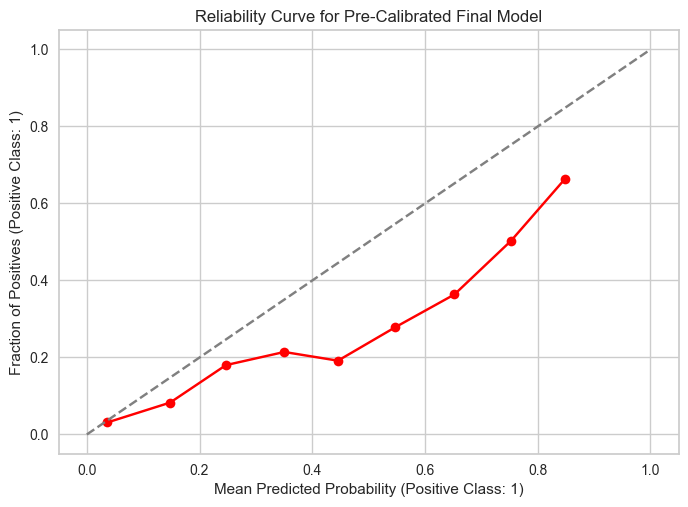

In [58]:
# predict probabilities on the test set
X_test = df_unseen.drop(columns=['customerID', 'Churn'])
y_test = df_unseen.Churn
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# compute calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

# plot Reliability Curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability (Positive Class: 1)')
plt.ylabel('Fraction of Positives (Positive Class: 1)')
plt.title('Reliability Curve for Pre-Calibrated Final Model')
plt.show()

**Note**

The red line, composed of points and connecting segments, represents the model's calibration performance. Deviation from the diagonal indicates miscalibration: probabilities lower than 0.4 slightly underpredict actual positive outcomes, while probabilities above 0.4 exhibit better alignment but still show mild overprediction as the line generally stays below the ideal diagonal. The increasing trend of the red line demonstrates that higher predicted probabilities are associated with higher actual positive rates, which is desirable but not perfectly calibrated. This visualization highlights the model's need for further calibration to align its predictions with actual observed outcomes.

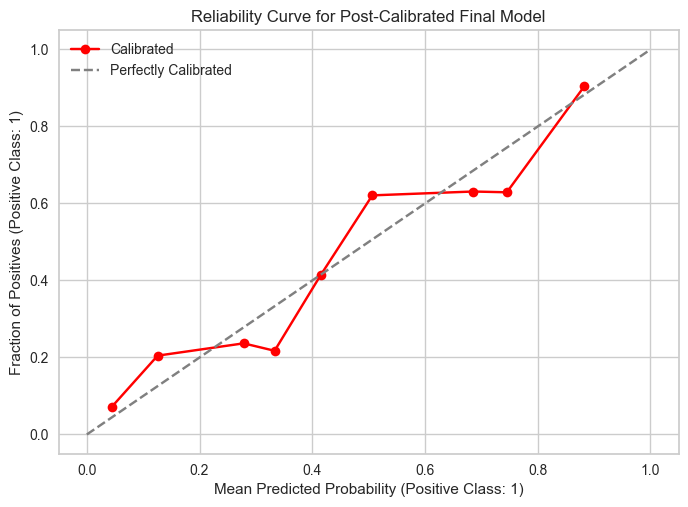

In [59]:
# calibration is applied on the validation set
X_val = val_nearmiss_set.drop(columns='Churn')
y_val = val_nearmiss_set.Churn

# calibrate the classifier using sigmoid method
calibrated_model = CalibratedClassifierCV(estimator=final_model, cv='prefit', method='isotonic')

# calibration process
calibrated_model.fit(X_val, y_val)

# predict probabilities on the test set
y_pred_proba = calibrated_model.predict_proba(X_test)[:, 1]

# compute calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

# plot the calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', color='red', label='Calibrated')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability (Positive Class: 1)')
plt.ylabel('Fraction of Positives (Positive Class: 1)')
plt.title('Reliability Curve for Post-Calibrated Final Model')
plt.legend(loc='best')
plt.show()

**Note** 

- The calibration curve for the post-calibrated final model demonstrates a significant improvement in aligning the predicted probabilities with the observed fraction of positives. The red line, representing the calibrated model, closely follows the dashed diagonal line of perfect calibration, particularly for mid-to-high probability ranges (0.4–1.0). This indicates that the model now provides reliable probabilistic predictions in these regions. For lower probability ranges (0.0–0.2), there is still a slight deviation, where the predicted probabilities slightly underestimate the observed fraction of positives. However, this discrepancy is minimal compared to the pre-calibration state, showcasing the effectiveness of the calibration process. 
- The overall alignment of the curve with the perfect calibration line reflects that the model is now well-calibrated, meaning its probability outputs are trustworthy for making decisions or threshold adjustments based on these probabilities. This improvement is particularly crucial for applications where accurate probability estimation is necessary for risk-based decisions.

### **5.2 Confusion Matrix & Cost-Saving Simulation: Uncalibrated vs Calibrated Model**

A confusion matrix displays how well a classification model is performing by showing the number of correct and incorrect predictions. It breaks down the results into four categories: true positives (correctly predicted positives), false positives (negatives incorrectly predicted as positives), true negatives (correctly predicted negatives), and false negatives (positives incorrectly predicted as negatives).

#### **5.2.1. Cost-saving simulation of uncalibrated model**

F5 Score: 0.815


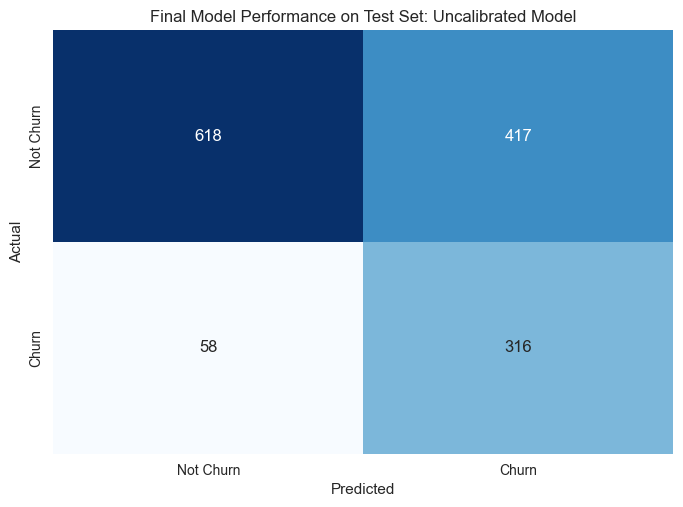

In [60]:
# predict on the test set
y_pred_test = final_model.predict(X_test)

# calculate F5 score
print(f"F5 Score: {fbeta_score(y_test, y_pred_test, beta=5).round(3)}")

# plot the confussion matrix
cm = confusion_matrix(y_test, y_pred_test)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', cbar=False)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Final Model Performance on Test Set: Uncalibrated Model')
ax.set_xticklabels(['Not Churn', 'Churn'])
ax.set_yticklabels(['Not Churn', 'Churn'])
plt.show()

**Scenario 1: Customer churn without models**
- Before we calculate the misclassification costs of the best model using the confusion matrix, let's recap: the cost per false positive is USD138.8, and the cost per false negative is USD694.
- Without the model, there are 374 actual churns missed, resulting in $$374 \: \text{churns} \times \$694 = \$259,556$$

**Scenario 2: Customer churn with models**
- False positives (actual Not Churn, predicted Churn): $$417 \: \text{errors} \times \$138.8 = \$57,879.6$$
- False negatives (actual Churn, predicted Not Churn): $$58 \: \text{errors} \times \$694 = \$40,252$$
- In total, the financial cost to the company due to the model's misclassification is **USD98,131.6**
- Considering both scenarios, it means the model can save:
$$\$259,556 - \$98,131.6 = \$161,424.4$$

#### **5.2.2 Cost-saving simulation of calibrated model**

F5 Score: 0.491


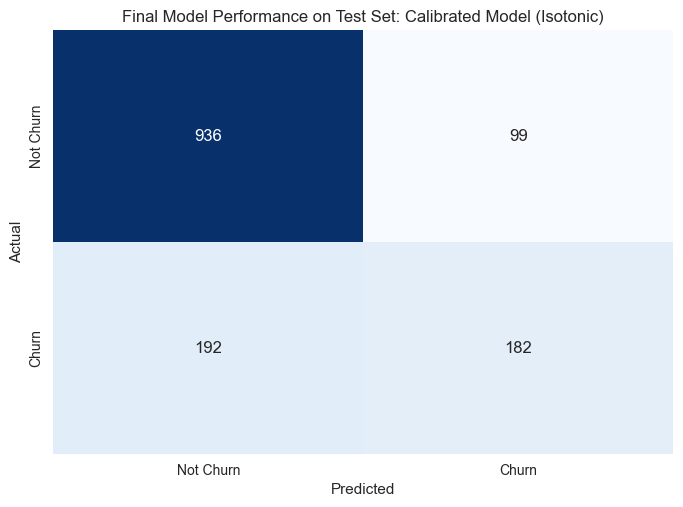

In [61]:
# predict on the test set
y_pred_test = calibrated_model.predict(X_test)

# calculate F5 score
print(f"F5 Score: {fbeta_score(y_test, y_pred_test, beta=5).round(3)}")

# plot the confussion matrix
cm = confusion_matrix(y_test, y_pred_test)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', cbar=False)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Final Model Performance on Test Set: Calibrated Model (Isotonic)')
ax.set_xticklabels(['Not Churn', 'Churn'])
ax.set_yticklabels(['Not Churn', 'Churn'])
plt.show()

**Scenario 1: Customer churn without models**
- Without the model, there are 374 actual churns missed, resulting in $$374 \: \text{churns} \times \$694 = \$259,556$$

**Scenario 2: Customer churn with models** 
- False positives (actual Not Churn, predicted Churn): $$99 \: \text{errors} \times \$138.8 = \$13,741.2$$
- False negatives (actual Churn, predicted Not Churn): $$192 \: \text{errors} \times \$694 = \$133,248$$
- In total, the financial cost to the company due to the model's misclassification is **USD146,989.2**
- Considering both scenarios, it means the model can save:
$$\$259,556 - \$146,989.2 = \$112,566.8$$

**Financial impact consideration**

Based on the evaluation, the uncalibrated model outperformed the calibrated model in terms of F5 score (0.815 vs. 0.491) and loss cost (USD 98,131 vs. USD 146,989). Although the calibrated model achieved perfect calibration by aligning to the diagonal line, but, the significant decrease in the F5 score and the drastic increase in the loss cost indicate that the better probabilistic accuracy did not translate into better decision-making or cost optimization. The uncalibrated model, despite having high and low confidence levels, shows superior performance in minimizing the cost of loss, which is the main objective in this context. Therefore, the uncalibrated model should be chosen, as it achieves a better balance between model performance and financial impact.

And another consideration is that Logistic Regression theoretically produces well-calibrated probabilities, as the model is designed to maximize the likelihood of the data, so its predictions reflect the probability of the positive class. However, in practice, there are certain conditions where additional calibration is required. 

### **5.3 Global Explanation: SHAP Plot**

Since final model makes complex decisions based on numerous interactions between features, which can be hard to interpret directly, we use SHAP plot for getting the feature importance. This plot visualizes how much each feature contributes to the model's prediction based on game theory. By utilizing this plot, we can gain an understanding of the general behavior of the final model and show which features have the most significant impact (both positive or negative).

In [81]:
# apply preprocessing to get the transformed feature names
X_train_transformed = final_model[:-1].transform(df_seen.drop(columns=['customerID', 'Churn']))
X_test_transformed = final_model[:-1].transform(X_test)

# get feature names
unique_feature_names = X_test_transformed.columns

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(final_model[-1].predict_proba, X_train_transformed, link="identity")
shap_values = explainer.shap_values(X_test_transformed, nsamples=100)

Using 5634 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1409 [00:00<?, ?it/s]

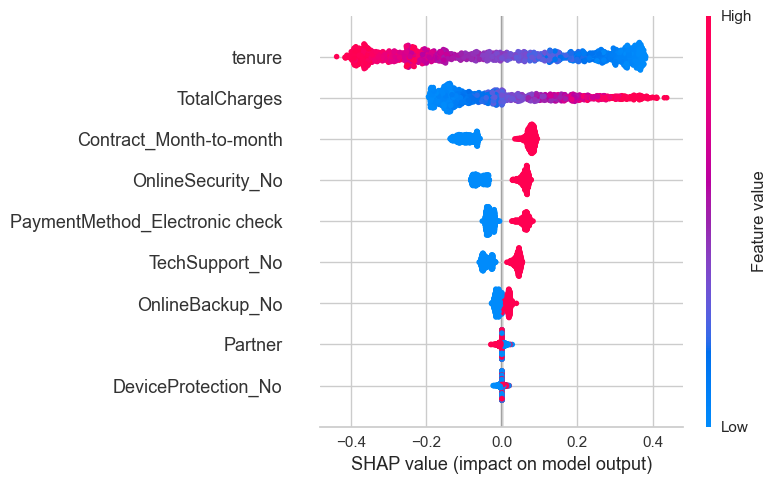

In [82]:
# visualize global feature importance
shap.summary_plot(shap_values[1], X_test_transformed, 
                  feature_names=unique_feature_names, 
                  title="SHAP Summary Plot",
                  plot_size=(8, 5))

**Note**

This SHAP summary plot visualizes the impact of feature values on the model's output, with the x-axis representing the SHAP values (positive values push the model toward predicting churn, while negative values push it away from churn). Each dot corresponds to a single customer, with color indicating the feature value (red for high, blue for low). For example, higher tenure (blue) decreases the likelihood of churn, while lower tenure (red) increases it. In contrast, high TotalCharges (red) tend to increase churn probability. Features such as Contract_Month-to-month and missing OnlineSecurity or TechSupport significantly influence churn predictions, with high values (red) typically contributing to churn. This plot emphasizes the relationship between individual feature values and their contribution to churn prediction, enabling actionable insights for targeted interventions.

### **5.4 Local Explanation: Counterfactual**
To enhance the interpretability of our best-performing customer churn prediction model, we use counter factual explanation. Just a quick explanation, counterfactual explanation is a XAI method to understand a model's decision by showing how the outcome would change with different input data (see [Mothilal, Sharma, & Tan, 2020](https://arxiv.org/abs/1905.07697) for the introduction). It helps answer the question, "What if the input data were different?" This approach not only helps us understand the key drivers behind the model's predictions but also provides actionable insights for strategies to prevent customers from churning.

In [70]:
# specify numerical columns
cont_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# define the data interface
data_interface = dice_ml.Data(dataframe=df_seen.drop(columns='customerID'), continuous_features=cont_features, outcome_name='Churn')

# define the model interface
model_interface = dice_ml.Model(model=final_model, backend='sklearn')

# initialize Dice
dice = Dice(data_interface, model_interface)

Suppose there is one customer that the model predicts will churn with a probability of 0.63

In [71]:
# choose customer sample
cust_sample = X_test.loc[7025:7025, :]

# show prediction result
display(show_predict(final_model, cust_sample))

Original Outcome: 1


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,proba_0,proba_1
7025,Female,No,No,No,18,Yes,Yes,Fiber optic,No,No,...,No,Yes,Month-to-month,Yes,Bank transfer (automatic),95.05,1679.4,1,0.37,0.63


Here we exemplify intervening on two features, namely `Tenure` and `Total Charges`, based on the SHAP output. The selection of these two features is based on the features that are most likely to be intervened by the Customer Experience Manager, supported by the Marketing Manager, such as providing loyalty programs and targeted offers. 

**Simulating Tenure**

In [72]:
np.random.seed(42)
random.seed(42)

# generate counterfactuals
cf = dice.generate_counterfactuals(cust_sample, desired_class=0, total_CFs=3, features_to_vary=['tenure'])

# extract counterfactual instances
counterfactual_instances = cf.cf_examples_list[0].final_cfs_df

# predict probabilities for the counterfactuals
cf_probs = final_model.predict_proba(counterfactual_instances.drop(columns='Churn'))

# add predicted probabilities for class 1 and 0
counterfactual_instances['proba_0'] = cf_probs[:, 0].round(2)
counterfactual_instances['proba_1'] = cf_probs[:, 1].round(2)

# display output
counterfactual_instances

100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,proba_0,proba_1
0,Female,No,No,No,55,Yes,Yes,Fiber optic,No,No,...,No,Yes,Month-to-month,Yes,Bank transfer (automatic),95.05,1679.4,0,0.92,0.08
1,Female,No,No,No,70,Yes,Yes,Fiber optic,No,No,...,No,Yes,Month-to-month,Yes,Bank transfer (automatic),95.05,1679.4,0,0.98,0.02
2,Female,No,No,No,36,Yes,Yes,Fiber optic,No,No,...,No,Yes,Month-to-month,Yes,Bank transfer (automatic),95.05,1679.4,0,0.72,0.28


**Note**
- The counterfactual explanation indicates that increasing the `Tenure` from 2 to higher values (e.g. 36, 55, and 70) would change the outcome from churn to not churn. This finding makes sense since previously we already discovered that churned customers usually have shorter tenure. This suggests that decresing tenure (customer's duration with the company) significantly influences the likelihood of churning.
- Based on this output, in order to encourage long-term customer retention, we can propose an idea to the Customer Experience Maneger to implement or enhance loyalty programs that reward loyal customers and provide personalized discounts or offers based on customer tenure, making them feel valued and appreciated.

**Simulating Total Charges**

In [73]:
np.random.seed(42)
random.seed(42)

# generate counterfactuals
cf = dice.generate_counterfactuals(cust_sample, desired_class=0, total_CFs=3, features_to_vary=['TotalCharges'])

# extract counterfactual instances
counterfactual_instances = cf.cf_examples_list[0].final_cfs_df

# predict probabilities for the counterfactuals
cf_probs = final_model.predict_proba(counterfactual_instances.drop(columns='Churn'))

# add predicted probabilities for class 1 and 0
counterfactual_instances['proba_0'] = cf_probs[:, 0].round(2)
counterfactual_instances['proba_1'] = cf_probs[:, 1].round(2)

# display output
counterfactual_instances

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,proba_0,proba_1
0,Female,No,No,No,18,Yes,Yes,Fiber optic,No,No,...,No,Yes,Month-to-month,Yes,Bank transfer (automatic),95.05,659.6,0,0.54,0.46
1,Female,No,No,No,18,Yes,Yes,Fiber optic,No,No,...,No,Yes,Month-to-month,Yes,Bank transfer (automatic),95.05,713.1,0,0.53,0.47
2,Female,No,No,No,18,Yes,Yes,Fiber optic,No,No,...,No,Yes,Month-to-month,Yes,Bank transfer (automatic),95.05,316.4,0,0.60,0.40


**Note**
- The counterfactual explanation indicates that decreasing the `Total Charges` from USD1679.4 to higher values (e.g. 316, 713, and 659) would change the outcome from churn to not churn. This finding makes sense since previously we already discovered that churned customers usually have high Total Charges. This suggests that increasing Total Charges significantly influences the likelihood of churning.
- Based on this output, in order to encourage long-term customer retention, we can propose an idea to the Customer Experience Maneger to implement pricing plans programs or loyalty discounts, making them satisfaction with perceived high costs.

### **5.5 Churn Reduction Simulation**
In order this churn reduction simulation to work using the model, we need several assumptions: (1) The model has been deployed in the production environment and used by the CX Manager to predict customer churns. (2) The Customer Experience Manager with the support of Marketing Manager already carried out an intrvention to at-risk customers with retention success rate at 50%.

And now, let us break down the logic of the calculation which we will implement it on the function below:
1. Calculate the current churned customers. The churn rate can be adjusted to the rate in which another simulation is done. But for a starting point, let's use the churn rate based on the EDA, i.e., 26.5%. 
$$\text{current churners} = \text{total customers} \times \text{churn rate}$$
2. Calculate the number of churners to retain. This number of customers is obtained from the model's predictions and multiplied by the success rate of the stakeholder's intervention. For example, the stakeholder runs targeted intervention to the at-risk customers (those predicted as churn by the model). 
$$\text{retained churners} = \text{predicted churners} \times \text{retention success rate}$$
3. Calculate the number of new churners. This number is based on the total of current churners substrated by the retained ones. 
$$\text{new churners} = \text{current churners} - \text{retained churners}$$ 
4. Calculate new churn rate by dividing new churners from total customers. $$\text{new churn rate} = \frac{\text{new churners}}{\text{total customers}}$$

In [74]:
# build function for the simulation
def simulate_churn_reduction(total_customers, current_churn_rate, predicted_churners, retention_success_rate):
    current_churners = total_customers * current_churn_rate
    retained_churners = predicted_churners * retention_success_rate
    new_churners = current_churners - retained_churners
    new_churn_rate = new_churners / total_customers
    return new_churn_rate

# assumptions
total_customers = 10000
current_churn_rate = 0.265
predicted_churners = 1600
retention_success_rate = 0.5

# perform simulation
new_churn_rate = simulate_churn_reduction(total_customers, current_churn_rate, predicted_churners, retention_success_rate)
print(f"New Churn Rate: {new_churn_rate * 100:.2f}%")

New Churn Rate: 18.50%


**Note**
- Based on the assumptions, the model has been used to predict 10,000 customers, and there are 1,600 users susceptible to churn so the CX Manager implemented a targeted intervention, i.e., offerring 10% cashback with certain max valuee for the customer's next purchase. This marketing startegy is assumed to have 50% success rate.
- From this point, the churn rate will be 18.50%, or a reduction of about 8%, slightly below the target of 10%. 

### **5.6 Model Saving**

In [75]:
import joblib 

# save model
joblib.dump(final_model, '../model/clf_final.pkl')

['../model/clf_final.pkl']

<a id="numerical"></a>
## <b><span style='color:darkturquoise'>Section 6 |</span><span style='color:darkblue'> Conclusion & Recommendation</span></b>

____

### **6.1 Summary**

In this project, we try to address the problem of customer churn rate by reducing it by 10%. Because the current churn rate can be considered “bad” by telco standards (typical churn rate: 26%), and could potentially cause more financial loss to the company. To achieve the business objectives, the project involved diagnostic analysis on historical data to understand customer churn. Specifically, the analysis was conducted by comparing customers who churned and did not churn with a focus on customer demographics, service subscription, and billing & payment.

**1. Data analysis**

- Customer churn is characterized by several distinct patterns. Churned customers often have shorter tenure with the company, indicating a lack of long-term commitment. They tend to have higher monthly charges, which might contribute to dissatisfaction, but lower total charges, reflecting their limited time as customers. These individuals are more likely to have month-to-month contracts, prefer the convenience of paperless billing, and use electronic checks for payments. 
- Many churned customers opt for fiber optic internet services and maintain multiple phone lines, possibly reflecting a higher dependence on connectivity services. However, they are less likely to subscribe to additional technology services like online security or backup but are more inclined to use streaming-related add-on services. 
- Demographically, churned customers are often senior citizens who lack a partner and are not financially dependent, which may affect their purchasing priorities and need for bundled services. These behavioral and demographic trends provide valuable insights into understanding and addressing customer churn.

**2. Predictive modeling**

- Our predictive modeling prioritizes minimizing false negatives (actual 1, predicted 0) more than false positives (actual 0 predicted 1) as the financial cost of FN is 5 times more expensive than that of FP. Four experiments utilizing different sampling techniques to address class imbalance problem, Logistic Regression, particularly from Experiment 2, using SMOTE emerged as the top performing model based on its minimum misclassification cost (FN).  
- Using this model, we found that some features, namely `Tenure`, `Total Charges`, and `Contract Month-to-month`, significantly influence the likelihood of churns. We also have explored how changing values in specific features can change the predictions, highlighting the importance of these features in influencing the likelihood of churns.

### **6.2 Recommendations**

For customer experience manager, there are several key factors to focus on in reducing churn:
- Implement or enhance loyalty programs (if already exists) to reward long-term customers, encouraging longer stays and higher total charges. This can be achieved through tiered rewards or exclusive offers based on their tenure.
- Use personalized marketing campaigns to target customers who currently do not have Online Security, Online Backup, or Device Protection. Showcase testimonials, benefits, and potential risks of not subscribing.
- Encourage customers to switch to automated payment methods such as credit card or bank transfer.
- Utilize the model's predictions to proactively flag at-risk customers to prevent them from leaving. Taking the model's predictions into considerations enables the company to save more money because manager can implement targeted interventions to at-risk customers in order to reduce the number of churners.

 <h1 span style='text-align:center; font-weight:bold; color:orange'>---END---</h1>